In [1]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
# from dotenv import load_dotenv
# from pathlib import Path
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

## Load pair df

In [2]:
import os
from datetime import datetime, timedelta, timezone
from pathlib import Path
import re
import pandas as pd
import requests

DB_DIR = Path("dbs")
BAD_SUFFIXES = ("UPUSDT","DOWNUSDT","BULLUSDT","BEARUSDT","3LUSDT","3SUSDT","5LUSDT","5SUSDT")


def interval_slug(s: str) -> str:
    return s.strip().replace(" ", "").replace("/", "").lower()

def make_db_name(pair: str, interval: str, weeks: int) -> str:
    return f"{pair}_{interval_slug(interval)}_{weeks}weeks.db"

def list_downloaded_pairs(db_dir=DB_DIR):
    """
    Returns list of symbols inferred from SQLite filenames in db_dir.
    Assumes file contains a token like BTCUSDT somewhere in the name.
    """
    symbols = set()

    for p in Path(db_dir).glob("*.db"):
        name = p.stem  # filename without extension
        # find the first token that looks like a Binance symbol ending with USDT
        m = re.search(r"([A-Z0-9]{2,20}USDT)", name.upper())
        if m:
            symbols.add(m.group(1))

    # filter out leveraged tokens etc
    symbols = [s for s in symbols if s.endswith("USDT") and not s.endswith(BAD_SUFFIXES)]
    return sorted(symbols)
    
def load_or_fetch_pair_df(pair: str, interval: str, weeks: int) -> tuple[str, "pd.DataFrame"]:
    db_name = make_db_name(pair, interval, weeks)
    db_path = "./db/" + db_name

    print(f"[{pair}] DB: {db_path}")

    binance_client = BinanceClient(db_path)
    binance_client.set_interval(interval)

    df = None

    if os.path.exists(db_path):
        df = binance_client.fetch_data_from_db(pair)
        if df is not None and not df.empty:
            print(f"[{pair}] Loaded {len(df):,} rows from DB.")
        else:
            df = None

    if df is None:
        print(f"[{pair}] No usable DB data found -> fetching from Binance...")

        api_secret = os.getenv("BINANCE_SECRET_KEY")
        api_key = os.getenv("BINANCE_API_KEY")
        binance_client.make(api_key, api_secret)

        server_time = binance_client.get_server_time()
        end_dt = datetime.fromtimestamp(server_time["serverTime"] / 1000, tz=timezone.utc)
        start_dt = end_dt - timedelta(weeks=weeks)

        start_ms = int(start_dt.timestamp() * 1000)
        end_ms = int(end_dt.timestamp() * 1000)

        data = binance_client.fetch_data(pair, start_ms, end_ms)
        if data is None or data.empty:
            raise RuntimeError(f"[{pair}] No data returned from Binance for the requested range.")

        binance_client.store_data_to_db(pair, data)

        df = binance_client.fetch_data_from_db(pair)
        if df is None or df.empty:
            raise RuntimeError(f"[{pair}] Data fetched/stored but DB load returned empty.")

        print(f"[{pair}] Fetched + stored + loaded {len(df):,} rows.")

    df = df.sort_index()
    return db_path, df


In [9]:
import pandas as pd
import numpy as np
import bottleneck as bn

def detect_volume_shocks(
    df,
    vol_win=144,          # 12h median
    impulse_k=12,         # 60 min impulse
    rvol_thresh=6.0,
    impulse_thresh=0.04,
    lookahead=24,
    cooldown=12,
):
    # ✅ keep NaN check exactly (dropna) and keep copy (same as you had)
    d = df[["open","high","low","close","volume"]].dropna().copy()
    n = len(d)
    if n == 0:
        return pd.DataFrame()

    # --- rolling median (same structural step)
    # If you want extra speed without changing logic, you can optionally use bottleneck.
    # But we’ll keep pandas by default (safe & identical).
    
    # vol_med = d["volume"].rolling(vol_win).median()
    vol_np = d["volume"].to_numpy(dtype=np.float64)
    vol_med_np = bn.move_median(vol_np, window=vol_win, min_count=vol_win)
    vol_med = pd.Series(vol_med_np, index=d.index)
    rvol = d["volume"] / vol_med

    # Signed impulse (direction)
    impulse_signed = d["close"] / d["close"].shift(impulse_k) - 1
    # Absolute impulse (magnitude)
    impulse_abs = impulse_signed.abs()

    # --- convert once to numpy arrays (biggest speedup; structure unchanged)
    close_np = d["close"].to_numpy(dtype=np.float64)
    rvol_np = rvol.to_numpy(dtype=np.float64)
    imp_abs_np = impulse_abs.to_numpy(dtype=np.float64)
    imp_signed_np = impulse_signed.to_numpy(dtype=np.float64)

    # index as numpy array (fast access)
    idx_np = d.index.to_numpy()

    events = []

    # start i at max(vol_win, impulse_k) to avoid early NaNs
    start_i = max(vol_win, impulse_k)
    i = start_i

    end_i = n - lookahead

    # localize thresholds (tiny but free speed)
    rv_th = float(rvol_thresh)
    im_th = float(impulse_thresh)

    # localize append (tiny but free speed)
    ev_append = events.append

    while i < end_i:
        rv = rvol_np[i]
        ia = imp_abs_np[i]

        # keep same condition structure
        if (rv >= rv_th) and (ia >= im_th):
            px0 = close_np[i]
            isg = imp_signed_np[i]

            ev_append({
                "event_ts": idx_np[i],
                "close_event": float(px0),
                "rvol": float(rv),
                # keep existing name as magnitude for backward-compat
                "impulse": float(ia),
                # new: signed impulse for direction
                "impulse_signed": float(isg),
                "shock_direction": "long" if isg > 0 else "short",
            })
            i += cooldown
        else:
            i += 1

    return pd.DataFrame(events)


In [4]:
interval = "5m"
weeks = 52

paths = {}
dfs = {}

pairs = list_downloaded_pairs("db")

for sym in pairs:
    db_path, df = load_or_fetch_pair_df(sym, interval, weeks)
    paths[sym] = db_path
    dfs[sym] = df
    dfs[sym] = df


[0GUSDT] DB: ./db/0GUSDT_5m_52weeks.db
[0GUSDT] Loaded 36,249 rows from DB.
[1INCHUSDT] DB: ./db/1INCHUSDT_5m_52weeks.db
[1INCHUSDT] Loaded 104,832 rows from DB.
[2ZUSDT] DB: ./db/2ZUSDT_5m_52weeks.db
[2ZUSDT] Loaded 33,383 rows from DB.
[AAVEUSDT] DB: ./db/AAVEUSDT_5m_52weeks.db
[AAVEUSDT] Loaded 104,832 rows from DB.
[ADAUSDT] DB: ./db/ADAUSDT_5m_52weeks.db
[ADAUSDT] Loaded 104,832 rows from DB.
[AGLDUSDT] DB: ./db/AGLDUSDT_5m_52weeks.db
[AGLDUSDT] Loaded 104,832 rows from DB.
[ALGOUSDT] DB: ./db/ALGOUSDT_5m_52weeks.db
[ALGOUSDT] Loaded 104,832 rows from DB.
[ALLOUSDT] DB: ./db/ALLOUSDT_5m_52weeks.db
[ALLOUSDT] Loaded 21,807 rows from DB.
[APTUSDT] DB: ./db/APTUSDT_5m_52weeks.db
[APTUSDT] Loaded 104,832 rows from DB.
[ARBUSDT] DB: ./db/ARBUSDT_5m_52weeks.db
[ARBUSDT] Loaded 104,832 rows from DB.
[ASTERUSDT] DB: ./db/ASTERUSDT_5m_52weeks.db
[ASTERUSDT] Loaded 32,185 rows from DB.
[ASTRUSDT] DB: ./db/ASTRUSDT_5m_52weeks.db
[ASTRUSDT] Loaded 104,832 rows from DB.
[AUCTIONUSDT] DB: ./db/

## Load COINS, then align timestamps

In [10]:
from tqdm.auto import tqdm
events = []

# for sym, df_feat in tqdm(instability_cache.items(), desc="Cond prob (fast)"):
for sym, df in tqdm(dfs.items()):
    ev = detect_volume_shocks(df)      # ✅ no sym passed
    if not ev.empty:
        ev["symbol"] = sym
        events.append(ev)

events = pd.concat(events, ignore_index=True) if events else pd.DataFrame()


  0%|          | 0/119 [00:00<?, ?it/s]

In [11]:
len(events)            # should be thousands, not tens
events["impulse"].describe()
events["rvol"].describe()


count    11616.000000
mean        28.966698
std        111.713244
min          6.000611
25%          7.929327
50%         11.867675
75%         22.974922
max       7870.043554
Name: rvol, dtype: float64

## Detect Comporession state

In [12]:
import pandas as pd
import numpy as np

def detect_compression_state(
    df: pd.DataFrame,
    *,
    atr_short: int = 20,          # ~100 min on 5m
    atr_long: int = 100,          # ~8 hours on 5m
    vol_win: int = 144,           # volume median window (12 hours)
    vol_ratio_thresh: float = 0.6,
    rvol_thresh: float = 0.6,
    min_duration: int = 12        # bars of sustained compression (60 min)
):
    """
    Detects pre-shock compression state.

    Returns df with added columns:
      - atr
      - atr_med
      - vol_compression
      - rvol
      - volu_compression
      - compression_raw
      - compression_duration
      - is_compressed
    """

    d = df.copy().sort_index()
    d = d[["open","high","low","close","volume"]].dropna()

    # -----------------------
    # 1) Volatility (ATR)
    # -----------------------
    high = d["high"]
    low  = d["low"]
    close = d["close"]

    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)

    d["atr"] = tr.rolling(atr_short).mean()
    d["atr_med"] = d["atr"].rolling(atr_long).median()

    d["vol_compression"] = d["atr"] / d["atr_med"]
    d["is_vol_compressed"] = d["vol_compression"] <= vol_ratio_thresh

    # -----------------------
    # 2) Volume compression
    # -----------------------
    vol_med = d["volume"].rolling(vol_win).median()
    d["rvol"] = d["volume"] / vol_med
    d["is_volume_compressed"] = d["rvol"] <= rvol_thresh

    # -----------------------
    # 3) Raw compression flag
    # -----------------------
    d["compression_raw"] = (
        d["is_vol_compressed"] &
        d["is_volume_compressed"]
    )

    # -----------------------
    # 4) Duration counter
    # -----------------------
    duration = np.zeros(len(d), dtype=int)

    for i in range(1, len(d)):
        if d["compression_raw"].iloc[i]:
            duration[i] = duration[i-1] + 1
        else:
            duration[i] = 0

    d["compression_duration"] = duration

    # -----------------------
    # 5) Final state
    # -----------------------
    d["is_compressed"] = d["compression_duration"] >= min_duration

    return d


In [13]:
def get_compression_times(df_c):
    """
    df_c = output of detect_compression_state(df)
    Returns DatetimeIndex of bars where compression starts
    (we take the FIRST bar of each compression block)
    """
    comp = df_c["is_compressed"]

    # compression start = is_compressed == True AND previous == False
    comp_start = comp & (~comp.shift(1).fillna(False))

    return df_c.index[comp_start]

def get_shock_times(events_sym):
    """
    events_sym = events filtered to one symbol
    Returns DatetimeIndex of shock timestamps
    """
    return pd.to_datetime(events_sym["event_ts"]).sort_values()

def compression_leads_shock(
    compression_times,
    shock_times,
    *,
    max_lead_minutes=120
):
    """
    For each compression start time, check whether
    a shock occurs within max_lead_minutes AFTER it.
    """
    lead_td = pd.Timedelta(minutes=max_lead_minutes)

    hits = 0
    for t in compression_times:
        if ((shock_times > t) & (shock_times <= t + lead_td)).any():
            hits += 1

    total = len(compression_times)

    return {
        "compression_events": total,
        "hits": hits,
        "hit_rate": hits / total if total > 0 else np.nan
    }



In [15]:
import numpy as np
import pandas as pd

# -----------------------------
# Helpers: ATR + linear slope
# -----------------------------
def _atr14(series_df: pd.DataFrame, n: int = 14) -> pd.Series:
    # Same TR definition, faster than concat+max(axis=1)
    h = series_df["high"]
    l = series_df["low"]
    c = series_df["close"]
    pc = c.shift(1)

    tr1 = (h - l)
    tr2 = (h - pc).abs()
    tr3 = (l - pc).abs()

    # elementwise max across the three Series (preserves index)
    tr = np.maximum(tr1.to_numpy(dtype=float),
         np.maximum(tr2.to_numpy(dtype=float), tr3.to_numpy(dtype=float)))
    tr = pd.Series(tr, index=series_df.index)

    return tr.rolling(n).mean()

def _lin_slope(y: np.ndarray) -> float:
    """Slope of y versus index (0..n-1). Returns 0 if too short or constant."""
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n < 3 or np.all(~np.isfinite(y)):
        return np.nan
    x = np.arange(n, dtype=float)
    y = y - np.nanmean(y)
    x = x - x.mean()
    denom = np.nansum(x * x)
    return float(np.nansum(x * y) / denom) if denom > 0 else 0.0

# -----------------------------
# Candle overlap + wick/body
# -----------------------------
def _overlap_ratio(window: pd.DataFrame) -> float:
    """Mean normalized overlap between consecutive candles (0..1-ish)."""
    if len(window) < 2:
        return np.nan
    h = window["high"].to_numpy(dtype=float)
    l = window["low"].to_numpy(dtype=float)
    rng = (h - l)
    rng[rng == 0] = np.nan

    ov = np.minimum(h[1:], h[:-1]) - np.maximum(l[1:], l[:-1])
    ov = np.maximum(ov, 0.0)
    ov_norm = ov / rng[1:]
    return float(np.nanmean(ov_norm))

def _wick_to_body_ratio(window: pd.DataFrame) -> float:
    """(upper+lower wick)/body averaged over window."""
    o = window["open"].to_numpy(dtype=float)
    c = window["close"].to_numpy(dtype=float)
    h = window["high"].to_numpy(dtype=float)
    l = window["low"].to_numpy(dtype=float)

    body = np.abs(c - o)
    body[body == 0] = np.nan

    upper = h - np.maximum(o, c)
    lower = np.minimum(o, c) - l
    wick = upper + lower
    return float(np.nanmean(wick / body))

# -----------------------------
# Feature extraction for one window
# -----------------------------
def extract_window_features(
    d: pd.DataFrame,
    t0: pd.Timestamp,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    atr_long_med_win: int = 144
) -> dict | None:
    """
    Compute pre-shock window features for a single event time t0.

    Window is: [t0 - pre_bars, t0 - gap_bars]
    Assumes d is indexed by datetime and has open/high/low/close/volume.
    """
    if not isinstance(d.index, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex")

    # Only sort if needed (same result, avoids repeated work)
    if not d.index.is_monotonic_increasing:
        d = d.sort_index()

    # Need baseline columns (same logic)
    if "atr14" not in d.columns:
        d["atr14"] = _atr14(d, 14)
    if "vol_med_12h" not in d.columns:
        d["vol_med_12h"] = d["volume"].rolling(atr_long_med_win).median()
    if "rvol_12h" not in d.columns:
        d["rvol_12h"] = d["volume"] / d["vol_med_12h"]
    if "atr14_med_12h" not in d.columns:
        d["atr14_med_12h"] = d["atr14"].rolling(atr_long_med_win).median()

    # Locate t0 (same behavior)
    if t0 not in d.index:
        loc = d.index.searchsorted(t0, side="right") - 1
        if loc < 0:
            return None
        t0 = d.index[loc]

    # Faster get_loc if unique index; pandas handles both anyway
    end_loc = d.index.get_loc(t0) - gap_bars
    start_loc = end_loc - pre_bars + 1
    if start_loc < 0 or end_loc <= start_loc:
        return None

    # Keep copy (no functional change), but do minimal work before it
    w = d.iloc[start_loc:end_loc+1].copy()
    if len(w) < max(10, pre_bars // 2):
        return None

    # Baseline at window end
    atr_med = d["atr14_med_12h"].iloc[end_loc]
    if not np.isfinite(atr_med) or atr_med <= 0:
        return None

    # Pull arrays once (avoids repeated Series conversions)
    atr14_np = w["atr14"].to_numpy(dtype=float)
    rvol12_np = w["rvol_12h"].to_numpy(dtype=float)

    atr_mean = float(np.nanmean(atr14_np))
    atr_mean_ratio = atr_mean / float(atr_med)

    atr_slope = _lin_slope(atr14_np)
    rvol_mean = float(np.nanmean(rvol12_np))
    rvol_slope = _lin_slope(rvol12_np)

    # Use numpy for max/min (faster than Series reductions)
    high_np = w["high"].to_numpy(dtype=float)
    low_np  = w["low"].to_numpy(dtype=float)
    window_high = float(np.nanmax(high_np))
    window_low  = float(np.nanmin(low_np))

    window_close = float(w["close"].iloc[-1])
    range_pct = (window_high - window_low) / window_close if window_close != 0 else np.nan

    overlap_ratio = _overlap_ratio(w)
    wick_to_body = _wick_to_body_ratio(w)

    return {
        "t0": t0,
        "win_start": w.index[0],
        "win_end": w.index[-1],
        "atr_mean_ratio": atr_mean_ratio,
        "atr_slope": atr_slope,
        "rvol_mean": rvol_mean,
        "rvol_slope": rvol_slope,
        "range_pct": range_pct,
        "overlap_ratio": overlap_ratio,
        "wick_to_body_ratio": wick_to_body,
    }

# -----------------------------
# Build dataset: shock vs control
# -----------------------------
def build_preshock_dataset(
    dfs: dict[str, pd.DataFrame],
    events: pd.DataFrame,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    control_per_event: int = 1,
    control_lookahead_bars: int = 36,
    seed: int = 42,
) -> pd.DataFrame:
    """
    Returns a labeled dataset with:
      label=1 for pre-shock windows
      label=0 for matched control windows (same symbol, same window length)
    """
    rng = np.random.default_rng(seed)

    ev = events.copy()
    ev["event_ts"] = pd.to_datetime(ev["event_ts"])
    ev = ev.sort_values(["symbol", "event_ts"])

    rows = []
    rows_append = rows.append  # tiny speedup

    # Precompute shock times per symbol for fast control selection (same)
    shock_times_by_sym = {
        sym: pd.to_datetime(g["event_ts"]).sort_values().to_numpy(dtype="datetime64[ns]")
        for sym, g in ev.groupby("symbol", sort=False)
    }

    # constant used in control window end time (same as your 5-min bars assumption)
    bar_minutes = 5

    for sym, g in ev.groupby("symbol", sort=False):
        if sym not in dfs or dfs[sym].empty:
            continue

        d = dfs[sym].copy()
        if not d.index.is_monotonic_increasing:
            d = d.sort_index()

        d = d[["open","high","low","close","volume"]].dropna()
        if len(d) < (pre_bars + gap_bars + 200):
            continue

        if not isinstance(d.index, pd.DatetimeIndex):
            raise ValueError(f"{sym} df index must be DatetimeIndex")

        # Precompute baseline columns once per symbol (same)
        d["atr14"] = _atr14(d, 14)
        d["vol_med_12h"] = d["volume"].rolling(144).median()
        d["rvol_12h"] = d["volume"] / d["vol_med_12h"]
        d["atr14_med_12h"] = d["atr14"].rolling(144).median()

        shock_times = shock_times_by_sym.get(sym, np.array([], dtype="datetime64[ns]"))

        # Control sampling bounds (same)
        end_min = pre_bars + gap_bars
        end_max = len(d) - control_lookahead_bars - 1
        if end_max <= end_min:
            continue

        # Cache index for fast access
        d_index = d.index

        # Helper: fast future-shock check using binary search (same result as np.any mask)
        def _has_future_shock(t1n: np.datetime64, t2n: np.datetime64) -> bool:
            if shock_times.size == 0:
                return False
            # need shocks with (shock_times > t1n) & (shock_times <= t2n)
            j = shock_times.searchsorted(t1n, side="right")
            return (j < shock_times.size) and (shock_times[j] <= t2n)

        for t0 in pd.to_datetime(g["event_ts"]):
            # --- Positive (pre-shock) ---
            feat = extract_window_features(d, t0, pre_bars=pre_bars, gap_bars=gap_bars)
            if feat is None:
                continue

            feat.update({"symbol": sym, "label": 1})
            rows_append(feat)

            # --- Controls (non-shock) ---
            if control_per_event <= 0:
                continue

            attempts = 0
            got = 0
            feat_t0 = feat["t0"]  # cache

            while got < control_per_event and attempts < 200:
                attempts += 1
                end_loc = int(rng.integers(end_min, end_max))
                t_ctrl = d_index[end_loc]

                # Same leakage exclusion
                if abs((t_ctrl - feat_t0).total_seconds()) < 6 * 3600:
                    continue

                # Same future window definition
                t1 = t_ctrl
                t2 = t_ctrl + pd.Timedelta(minutes=bar_minutes * control_lookahead_bars)

                # Faster future shock check (same condition)
                if shock_times.size > 0:
                    t1n = t1.to_datetime64()
                    t2n = t2.to_datetime64()
                    if _has_future_shock(t1n, t2n):
                        continue

                feat_c = extract_window_features(d, t_ctrl, pre_bars=pre_bars, gap_bars=gap_bars)
                if feat_c is None:
                    continue

                feat_c.update({"symbol": sym, "label": 0})
                rows_append(feat_c)
                got += 1

    return pd.DataFrame(rows)


In [16]:

# Build dataset
ds = build_preshock_dataset(
    dfs=dfs,
    events=events,
    pre_bars=36,
    gap_bars=2,
    control_per_event=1,
    control_lookahead_bars=36,
    seed=42
)

ds.shape, ds["label"].value_counts()

((23232, 12),
 label
 1    11616
 0    11616
 Name: count, dtype: int64)

In [17]:
# Any NaNs?
ds.isna().mean().sort_values(ascending=False).head(10)

# Compare distributions quickly (shock vs control)
cols = ["atr_mean_ratio","atr_slope","rvol_mean","rvol_slope","range_pct","overlap_ratio","wick_to_body_ratio"]
ds.groupby("label")[cols].median().T


label,0,1
atr_mean_ratio,1.007246e+00,1.198457
atr_slope,-6.613348e-08,0.000013
rvol_mean,1.454077e+00,2.428586
rvol_slope,-9.556371e-04,0.048889
range_pct,2.436882e-02,0.053401
overlap_ratio,5.714020e-01,0.577975
wick_to_body_ratio,1.413972e+00,1.833683


In [18]:
import numpy as np
import pandas as pd

def compute_instability_features_over_window(
    d: pd.DataFrame,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    vol_med_win: int = 144
) -> pd.DataFrame:
    """
    Adds rolling-window (per bar) pre-shock features aligned to each bar t0,
    computed from [t0-pre_bars, t0-gap_bars].
    Output columns are same as dataset: atr_mean_ratio, atr_slope, rvol_mean, rvol_slope,
    range_pct, wick_to_body_ratio.
    """
    df = d.copy()
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()

    # ✅ keep NaN check (dropna) exactly as before
    df = df[["open","high","low","close","volume"]].dropna()

    # precompute base series (same)
    df["atr14"] = _atr14(df, 14)
    df["atr14_med_12h"] = df["atr14"].rolling(vol_med_win).median()
    df["vol_med_12h"] = df["volume"].rolling(vol_med_win).median()
    df["rvol_12h"] = df["volume"] / df["vol_med_12h"]

    n = len(df)
    cols = ["atr_mean_ratio","atr_slope","rvol_mean","rvol_slope","range_pct","wick_to_body_ratio"]

    # Pre-fill with NaNs (same end result, much faster than df.at in a loop)
    out_atr_mean_ratio = np.full(n, np.nan, dtype=np.float64)
    out_atr_slope      = np.full(n, np.nan, dtype=np.float64)
    out_rvol_mean      = np.full(n, np.nan, dtype=np.float64)
    out_rvol_slope     = np.full(n, np.nan, dtype=np.float64)
    out_range_pct      = np.full(n, np.nan, dtype=np.float64)
    out_wick_body      = np.full(n, np.nan, dtype=np.float64)

    # Pull arrays once
    o = df["open"].to_numpy(dtype=np.float64)
    h = df["high"].to_numpy(dtype=np.float64)
    l = df["low"].to_numpy(dtype=np.float64)
    c = df["close"].to_numpy(dtype=np.float64)

    atr14 = df["atr14"].to_numpy(dtype=np.float64)
    atr14_med = df["atr14_med_12h"].to_numpy(dtype=np.float64)
    rvol12 = df["rvol_12h"].to_numpy(dtype=np.float64)

    # Precompute x-centered and denom for slope (window length is constant = pre_bars)
    # This matches _lin_slope behavior for fixed-length windows (same linear regression formula)
    x = np.arange(pre_bars, dtype=np.float64)
    x = x - x.mean()
    denom = np.nansum(x * x)  # constant > 0 for pre_bars>=2

    def _lin_slope_fixed(y_window: np.ndarray) -> float:
        # Same handling as _lin_slope: if too short / all nonfinite => nan
        # Here length is fixed, but keep guard for robustness.
        if y_window.size < 3 or np.all(~np.isfinite(y_window)):
            return np.nan
        yw = y_window - np.nanmean(y_window)
        # if denom is 0 (shouldn't happen), return 0 like original
        return float(np.nansum(x * yw) / denom) if denom > 0 else 0.0

    start_endloc = pre_bars + gap_bars
    if n <= start_endloc:
        # add columns and return quickly
        df["atr_mean_ratio"] = out_atr_mean_ratio
        df["atr_slope"] = out_atr_slope
        df["rvol_mean"] = out_rvol_mean
        df["rvol_slope"] = out_rvol_slope
        df["range_pct"] = out_range_pct
        df["wick_to_body_ratio"] = out_wick_body
        return df

    for end_loc in range(start_endloc, n):
        # window ends at end_loc-gap_bars
        w_end = end_loc - gap_bars
        w_start = w_end - pre_bars + 1

        atr_med = atr14_med[w_end]
        if not np.isfinite(atr_med) or atr_med <= 0:
            continue

        # Slice views (no DataFrame slicing)
        sl = slice(w_start, w_end + 1)

        atr_w = atr14[sl]
        rvol_w = rvol12[sl]

        atr_mean = float(np.nanmean(atr_w))
        out_atr_mean_ratio[end_loc] = atr_mean / float(atr_med)
        out_atr_slope[end_loc] = _lin_slope_fixed(atr_w)

        out_rvol_mean[end_loc] = float(np.nanmean(rvol_w))
        out_rvol_slope[end_loc] = _lin_slope_fixed(rvol_w)

        # Range pct
        window_high = float(np.nanmax(h[sl]))
        window_low  = float(np.nanmin(l[sl]))
        window_close = float(c[w_end])
        out_range_pct[end_loc] = (window_high - window_low) / window_close if window_close else np.nan

        # wick_to_body_ratio (same math as _wick_to_body_ratio, but on arrays)
        o_w = o[sl]; c_w = c[sl]; h_w = h[sl]; l_w = l[sl]
        body = np.abs(c_w - o_w)
        body[body == 0] = np.nan
        upper = h_w - np.maximum(o_w, c_w)
        lower = np.minimum(o_w, c_w) - l_w
        wick = upper + lower
        out_wick_body[end_loc] = float(np.nanmean(wick / body))

    # Assign columns once (much faster than df.at in loop)
    df["atr_mean_ratio"] = out_atr_mean_ratio
    df["atr_slope"] = out_atr_slope
    df["rvol_mean"] = out_rvol_mean
    df["rvol_slope"] = out_rvol_slope
    df["range_pct"] = out_range_pct
    df["wick_to_body_ratio"] = out_wick_body

    return df


def classify_instability(df_feat: pd.DataFrame) -> pd.Series:
    """
    Returns boolean Series indexed like df_feat: True when in pre-shock instability state.
    """
    return (
        (df_feat["rvol_mean"] >= 2.0) &
        (df_feat["rvol_slope"] > 0.0) &
        (df_feat["atr_mean_ratio"] >= 1.10) &
        (df_feat["wick_to_body_ratio"] >= 1.60) &
        (df_feat["range_pct"] >= 0.035)
    )


In [19]:
# sym = "BTCUSDT"
df_feat = compute_instability_features_over_window(dfs[sym])
df_feat["is_instability"] = classify_instability(df_feat)

df_feat["is_instability"].mean(), df_feat["is_instability"].tail(50)


(np.float64(0.033291361416361416),
 timestamp
 2026-01-26 02:15:00    False
 2026-01-26 02:20:00    False
 2026-01-26 02:25:00    False
 2026-01-26 02:30:00    False
 2026-01-26 02:35:00    False
 2026-01-26 02:40:00    False
 2026-01-26 02:45:00    False
 2026-01-26 02:50:00    False
 2026-01-26 02:55:00    False
 2026-01-26 03:00:00    False
 2026-01-26 03:05:00    False
 2026-01-26 03:10:00    False
 2026-01-26 03:15:00    False
 2026-01-26 03:20:00    False
 2026-01-26 03:25:00    False
 2026-01-26 03:30:00    False
 2026-01-26 03:35:00    False
 2026-01-26 03:40:00    False
 2026-01-26 03:45:00    False
 2026-01-26 03:50:00    False
 2026-01-26 03:55:00    False
 2026-01-26 04:00:00    False
 2026-01-26 04:05:00    False
 2026-01-26 04:10:00    False
 2026-01-26 04:15:00    False
 2026-01-26 04:20:00    False
 2026-01-26 04:25:00    False
 2026-01-26 04:30:00    False
 2026-01-26 04:35:00    False
 2026-01-26 04:40:00    False
 2026-01-26 04:45:00    False
 2026-01-26 04:50:00    

In [20]:
def best_threshold_youden(ds: pd.DataFrame, feature: str, higher_is_more_shock: bool = True):
    x = ds[feature].to_numpy(dtype=float)
    y = ds["label"].to_numpy(dtype=int)

    # candidate thresholds = percentiles (fast, robust)
    qs = np.linspace(5, 95, 91)
    thrs = np.percentile(x[np.isfinite(x)], qs)

    best = None
    for thr in thrs:
        pred = (x >= thr) if higher_is_more_shock else (x <= thr)
        pred = pred & np.isfinite(x)

        tp = np.sum((pred == 1) & (y == 1))
        fp = np.sum((pred == 1) & (y == 0))
        tn = np.sum((pred == 0) & (y == 0))
        fn = np.sum((pred == 0) & (y == 1))

        tpr = tp / (tp + fn) if (tp + fn) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        j = tpr - fpr

        if best is None or j > best["J"]:
            best = {"feature": feature, "thr": float(thr), "TPR": tpr, "FPR": fpr, "J": j}

    return best

features = ["rvol_mean","rvol_slope","atr_mean_ratio","wick_to_body_ratio","range_pct"]
best_list = [best_threshold_youden(ds, f, higher_is_more_shock=True) for f in features]
pd.DataFrame(best_list).sort_values("J", ascending=False)


,feature,thr,TPR,FPR,J
4,range_pct,0.036169,0.822056,0.257920,0.564136
1,rvol_slope,0.033651,0.577824,0.202221,0.375603
0,rvol_mean,1.965387,0.615789,0.304236,0.311553
2,atr_mean_ratio,1.136406,0.567924,0.292097,0.275826
3,wick_to_body_ratio,1.363767,0.718406,0.521608,0.196798


In [21]:
def mark_future_shock(df_feat: pd.DataFrame, events: pd.DataFrame, horizon_bars: int):
    """
    For each bar in df_feat, mark whether a shock occurs within the next horizon_bars.
    """
    shock_times = pd.to_datetime(events["event_ts"]).values

    df = df_feat.copy()
    df["future_shock"] = False

    idx = df.index.values
    for i in range(len(idx)):
        t0 = idx[i]
        t1 = idx[min(i + horizon_bars, len(idx) - 1)]
        # any shock in (t0, t1]?
        df.iloc[i, df.columns.get_loc("future_shock")] = np.any(
            (shock_times > t0) & (shock_times <= t1)
        )

    return df


In [22]:
def classify_pre_shock_instability_v1(df_feat: pd.DataFrame) -> pd.Series:
    """
    Rule-based pre-shock instability classifier.
    Calibrated via Youden J on your dataset.
    """
    return (
        (df_feat["range_pct"] >= 0.037) &
        (df_feat["rvol_slope"] >= 0.032) &
        (df_feat["rvol_mean"] >= 2.10)
    )


In [23]:

df_feat = compute_instability_features_over_window(dfs[sym])
df_feat["is_instability"] = classify_pre_shock_instability_v1(df_feat)

ev = events.query("symbol == @sym")
df_feat = mark_future_shock(df_feat, ev, horizon_bars=24)  # 120 min

p_base = df_feat["future_shock"].mean()
p_cond = df_feat.loc[df_feat["is_instability"], "future_shock"].mean()

p_base, p_cond, p_cond / p_base


(np.float64(0.030467796092796092),
 np.float64(0.12411279493573758),
 np.float64(4.073573111679162))

In [27]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Faster ATR (same definition)
# ------------------------------------------------------------
def _atr(series_df: pd.DataFrame, n: int = 14) -> pd.Series:
    h = series_df["high"]
    l = series_df["low"]
    c = series_df["close"]
    pc = c.shift(1)

    tr1 = (h - l).to_numpy(dtype=float)
    tr2 = (h - pc).abs().to_numpy(dtype=float)
    tr3 = (l - pc).abs().to_numpy(dtype=float)

    tr = np.maximum(tr1, np.maximum(tr2, tr3))
    tr = pd.Series(tr, index=series_df.index)

    return tr.rolling(n).mean()

def _lin_slope_fixed(y_window: np.ndarray, x_centered: np.ndarray, denom: float) -> float:
    # matches your _lin_slope behavior for fixed-length windows
    if y_window.size < 3 or np.all(~np.isfinite(y_window)):
        return np.nan
    ym = np.nanmean(y_window)
    yw = y_window - ym
    return float(np.nansum(x_centered * yw) / denom) if denom > 0 else 0.0

# ------------------------------------------------------------
# Optimized rolling/window features aligned to each bar t0
# ------------------------------------------------------------
def compute_instability_features_over_window(
    d: pd.DataFrame,
    *,
    pre_bars: int = 36,
    gap_bars: int = 2,
    vol_med_win: int = 144,   # 12h baseline
    atr_n: int = 14
) -> pd.DataFrame:
    df = d.copy()
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()

    # ✅ keep NaN check
    df = df[["open","high","low","close","volume"]].dropna()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df index must be DatetimeIndex")

    # base series (computed once) - same
    df["atr14"] = _atr(df, atr_n)
    df["atr14_med_12h"] = df["atr14"].rolling(vol_med_win).median()
    df["vol_med_12h"] = df["volume"].rolling(vol_med_win).median()
    df["rvol_12h"] = df["volume"] / df["vol_med_12h"]

    n = len(df)
    cols = ["atr_mean_ratio","atr_slope","rvol_mean","rvol_slope","range_pct","wick_to_body_ratio"]

    # Preallocate outputs (same final content as filling df.at)
    out_atr_mean_ratio = np.full(n, np.nan, dtype=np.float64)
    out_atr_slope      = np.full(n, np.nan, dtype=np.float64)
    out_rvol_mean      = np.full(n, np.nan, dtype=np.float64)
    out_rvol_slope     = np.full(n, np.nan, dtype=np.float64)
    out_range_pct      = np.full(n, np.nan, dtype=np.float64)
    out_wick_body      = np.full(n, np.nan, dtype=np.float64)

    # Pull arrays once
    o = df["open"].to_numpy(dtype=np.float64)
    h = df["high"].to_numpy(dtype=np.float64)
    l = df["low"].to_numpy(dtype=np.float64)
    c = df["close"].to_numpy(dtype=np.float64)

    atr14 = df["atr14"].to_numpy(dtype=np.float64)
    atr14_med = df["atr14_med_12h"].to_numpy(dtype=np.float64)
    rvol12 = df["rvol_12h"].to_numpy(dtype=np.float64)

    # Precompute slope x once (window length constant = pre_bars)
    x = np.arange(pre_bars, dtype=np.float64)
    x = x - x.mean()
    denom = float(np.nansum(x * x))  # constant

    start_endloc = pre_bars + gap_bars
    if n <= start_endloc:
        for col, arr in zip(cols, [out_atr_mean_ratio, out_atr_slope, out_rvol_mean, out_rvol_slope, out_range_pct, out_wick_body]):
            df[col] = arr
        return df

    for end_loc in range(start_endloc, n):
        # IMPORTANT: you align features to t0=end_loc,
        # but window end is w_end=end_loc-gap_bars (same as your code)
        w_end = end_loc - gap_bars
        w_start = w_end - pre_bars + 1

        atr_med = atr14_med[w_end]
        if not np.isfinite(atr_med) or atr_med <= 0:
            continue

        sl = slice(w_start, w_end + 1)

        atr_w = atr14[sl]
        rvol_w = rvol12[sl]

        atr_mean = float(np.nanmean(atr_w))
        out_atr_mean_ratio[end_loc] = atr_mean / float(atr_med)
        out_atr_slope[end_loc] = _lin_slope_fixed(atr_w, x, denom)

        out_rvol_mean[end_loc] = float(np.nanmean(rvol_w))
        out_rvol_slope[end_loc] = _lin_slope_fixed(rvol_w, x, denom)

        window_high = float(np.nanmax(h[sl]))
        window_low  = float(np.nanmin(l[sl]))
        window_close = float(c[w_end])
        out_range_pct[end_loc] = (window_high - window_low) / window_close if window_close else np.nan

        # Wick/body ratio (same math as your _wick_to_body_ratio)
        o_w = o[sl]; c_w = c[sl]; h_w = h[sl]; l_w = l[sl]
        body = np.abs(c_w - o_w)
        body[body == 0] = np.nan
        upper = h_w - np.maximum(o_w, c_w)
        lower = np.minimum(o_w, c_w) - l_w
        wick = upper + lower

        xratio = wick / body
        xratio = xratio[np.isfinite(xratio)]
        out_wick_body[end_loc] = float(np.mean(xratio)) if xratio.size else np.nan

    # Assign once (fast)
    df["atr_mean_ratio"] = out_atr_mean_ratio
    df["atr_slope"] = out_atr_slope
    df["rvol_mean"] = out_rvol_mean
    df["rvol_slope"] = out_rvol_slope
    df["range_pct"] = out_range_pct
    df["wick_to_body_ratio"] = out_wick_body

    return df


In [28]:
events_by_sym = {s: g["event_ts"].values for s, g in events.groupby("symbol")}

In [29]:
from tqdm.auto import tqdm
import time

# ============================================================
# FIX #1: Cache instability once per symbol (WITH PROGRESS)
# ============================================================
instability_cache = {}

t0 = time.time()

for sym in tqdm(pairs, desc="Computing instability per symbol"):
    if sym not in dfs:
        continue

    df = dfs[sym]
    if df is None or df.empty:
        continue
    
    df_feat = compute_instability_features_over_window(df)
    is_inst = classify_pre_shock_instability_v1(df_feat)
    instability_cache[sym] = pd.DataFrame({"is_instability": is_inst}, index=df_feat.index)

t1 = time.time()
print(f"Instability cache built in {(t1 - t0)/60:.2f} minutes")


Computing instability per symbol:   0%|          | 0/119 [00:00<?, ?it/s]

/tmp/ipykernel_941/2126901193.py:27: RuntimeWarning: invalid value encountered in subtract
  yw = y_window - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_941/2126901193.py:27: RuntimeWarning: invalid value encountered in subtract
  yw = y_window - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_941/2126901193.py:27: RuntimeWarning: invalid value encountered in subtract
  yw = y_window - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Instability cache built in 9.83 minutes


In [31]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def future_shock_flag(index: pd.DatetimeIndex, event_ts, horizon_bars: int) -> np.ndarray:
    """
    Returns boolean array: shock occurs within next horizon_bars (aligned to index).
    O(N) via cumulative sum, no per-bar scanning.
    """
    n = len(index)
    if event_ts is None or len(event_ts) == 0:
        return np.zeros(n, dtype=bool)

    shock_pos = index.searchsorted(pd.to_datetime(event_ts))
    shock_pos = shock_pos[(shock_pos >= 0) & (shock_pos < n)]
    if shock_pos.size == 0:
        return np.zeros(n, dtype=bool)

    shock_flag = np.zeros(n, dtype=np.int8)
    shock_flag[shock_pos] = 1

    c = np.cumsum(shock_flag, dtype=np.int32)
    c_pad = np.concatenate([[0], c])  # length n+1

    h = horizon_bars
    ends = np.minimum(np.arange(n) + h, n - 1)
    # sum in (i, i+h] = c[ends] - c[i]
    future_counts = c_pad[ends + 1] - c_pad[np.arange(n) + 1]
    return future_counts > 0

In [32]:
import time
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm

# ---- Worker must be TOP-LEVEL for multiprocessing (do not nest it) ----
def _worker_compute_instability(sym: str, df: pd.DataFrame):
    """
    Returns (sym, is_instability_df) where is_instability_df has one column: ['is_instability']
    """
    if df is None or df.empty:
        return sym, None

    df_feat = compute_instability_features_over_window(df)
    df_feat["is_instability"] = classify_pre_shock_instability_v1(df_feat)

    # Return only the small piece to reduce inter-process overhead
    out = df_feat[["is_instability"]].copy()
    return sym, out


def build_instability_cache_parallel(dfs: dict, pairs: list, n_workers: int = 12):
    tasks = [(sym, dfs[sym]) for sym in pairs if sym in dfs and dfs[sym] is not None and not dfs[sym].empty]

    instability_cache = {}
    t0 = time.time()

    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        futures = {ex.submit(_worker_compute_instability, sym, df): sym for sym, df in tasks}

        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"Instability x{n_workers}"):
            sym = futures[fut]
            try:
                sym2, out = fut.result()
                if out is not None:
                    instability_cache[sym2] = out
            except Exception as e:
                print(f"[{sym}] failed: {e}")

    t1 = time.time()
    print(f"Instability cache built for {len(instability_cache)}/{len(tasks)} symbols in {(t1-t0)/60:.2f} min")
    return instability_cache


# Choose how many cores to use
N_WORKERS = 4  # you said 10–12 is fine
instability_cache = build_instability_cache_parallel(dfs, pairs, n_workers=N_WORKERS)


Instability x4:   0%|          | 0/119 [00:00<?, ?it/s]

/tmp/ipykernel_941/2126901193.py:27: RuntimeWarning: invalid value encountered in subtract
  yw = y_window - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_941/2126901193.py:27: RuntimeWarning: invalid value encountered in subtract
  yw = y_window - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_941/2126901193.py:27: RuntimeWarning: invalid value encountered in subtract
  yw = y_window - ym
/home/ata/miniconda3/envs/binbot/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Instability cache built for 119/119 symbols in 2.89 min


In [33]:
rows = []
horizon_bars = 24  # 120 min

for sym, df_feat in tqdm(instability_cache.items(), desc="Cond prob (fast)"):
    ev_ts = events_by_sym.get(sym)
    if ev_ts is None or len(ev_ts) == 0:
        continue

    idx = df_feat.index
    is_inst = df_feat["is_instability"].to_numpy(dtype=bool)
    n_inst = int(is_inst.sum())
    if n_inst < 10:
        continue

    fut = future_shock_flag(idx, ev_ts, horizon_bars=horizon_bars)

    p_base = float(fut.mean())
    p_cond = float(fut[is_inst].mean())

    rows.append({
        "symbol": sym,
        "base_prob": p_base,
        "cond_prob": p_cond,
        "lift": (p_cond / p_base) if p_base > 0 else np.nan,
        "instability_rate": float(is_inst.mean()),
        "n_instability": n_inst,
        "n_shocks": int(len(ev_ts)),
    })

prob_df = pd.DataFrame(rows).sort_values("lift", ascending=False)
prob_df.head(20)

Cond prob (fast):   0%|          | 0/119 [00:00<?, ?it/s]

,symbol,base_prob,cond_prob,lift,instability_rate,n_instability,n_shocks
43,FDUSDUSDT,0.000353,0.500000,1416.648649,0.000210,22,2
39,EURUSDT,0.000343,0.243902,710.243902,0.000391,41,2
96,USDEUSDT,0.000901,0.322581,358.091398,0.000776,31,2
67,PAXGUSDT,0.000343,0.108696,316.521739,0.000878,92,2
89,SUNUSDT,0.007917,0.252704,31.917433,0.009701,1017,40
23,BTCUSDT,0.001841,0.050822,27.605102,0.006382,669,9
21,BNBUSDT,0.002766,0.053597,19.374622,0.013526,1418,13
52,JSTUSDT,0.003959,0.066004,16.672991,0.010550,1106,18
100,WBTCUSDT,0.001603,0.013575,8.470588,0.006324,663,7
36,ETCUSDT,0.012029,0.097806,8.130996,0.025651,2689,57


# Pre shock feature extraction

In [34]:
BAR_MINUTES = 5

PRE_HOURS = 12
BASE_HOURS = 72

PRE_BARS  = PRE_HOURS  * 60 // BAR_MINUTES   # 144
BASE_BARS = BASE_HOURS * 60 // BAR_MINUTES   # 864


## Helper Functions

In [35]:
def log_returns(close):
    return np.log(close).diff()

def price_entropy(close):
    net_move = abs(close.iloc[-1] - close.iloc[0])
    path_len = close.diff().abs().sum()
    return net_move / path_len if path_len > 0 else np.nan

def failed_micro_breakouts(close, high, low):
    hi = close.max()
    lo = close.min()
    rng = hi - lo
    if rng == 0:
        return 0

    upper = lo + 0.9 * rng
    lower = lo + 0.1 * rng

    failures = 0
    for i in range(1, len(close) - 1):
        if close.iloc[i] > upper and close.iloc[i + 1] < upper:
            failures += 1
        elif close.iloc[i] < lower and close.iloc[i + 1] > lower:
            failures += 1
    return failures

def extract_pre_shock_features(df, event_ts):
    """
    df: single-symbol OHLCV DataFrame
    event_ts: timestamp of shock (aligned to index)
    """

    try:
        event_loc = df.index.get_loc(event_ts)
    except KeyError:
        return None

    if event_loc < BASE_BARS:
        return None  # not enough history

    pre  = df.iloc[event_loc - PRE_BARS  : event_loc]
    base = df.iloc[event_loc - BASE_BARS : event_loc]

    # --- Returns
    r_pre  = log_returns(pre["close"])
    r_base = log_returns(base["close"])

    vol_ratio = r_pre.std() / r_base.std()

    # --- ATR proxy (true range)
    tr_pre  = (pre["high"] - pre["low"]).mean()
    tr_base = (base["high"] - base["low"]).mean()
    atr_ratio = tr_pre / tr_base

    # --- Entropy
    entropy = price_entropy(pre["close"])

    # --- Volume suppression
    vol_ratio_vol = pre["volume"].mean() / base["volume"].mean()

    # --- Failed breakouts
    failed = failed_micro_breakouts(
        pre["close"], pre["high"], pre["low"]
    )

    return {
        "vol_ratio": vol_ratio,
        "atr_ratio": atr_ratio,
        "entropy": entropy,
        "volume_ratio": vol_ratio_vol,
        "failed_breakouts": failed,
    }



In [36]:
import numpy as np
import pandas as pd

rows = []

for _, ev in events.iterrows():
    sym = ev["symbol"]
    ts  = ev["event_ts"]

    df = dfs.get(sym)
    if df is None:
        continue

    feats = extract_pre_shock_features(df, ts)
    if feats is None:
        continue

    feats["symbol"]   = sym
    feats["event_ts"] = ts

    rows.append(feats)

event_features_df = pd.DataFrame(rows)
event_features_df.set_index(["symbol", "event_ts"], inplace=True)


In [37]:
for col in ["vol_ratio", "atr_ratio", "entropy", "volume_ratio"]:
    event_features_df[f"z_{col}"] = (
        event_features_df[col] - event_features_df[col].mean()
    ) / event_features_df[col].std()

event_features_df["compression_score"] = (
    event_features_df[["z_vol_ratio", "z_atr_ratio",
                       "z_entropy", "z_volume_ratio"]]
    .sum(axis=1)
)


In [38]:
event_features_df.describe()

,vol_ratio,atr_ratio,entropy,volume_ratio,failed_breakouts,z_vol_ratio,z_atr_ratio,z_entropy,z_volume_ratio,compression_score
count,11451.000000,11451.000000,11451.000000,11451.000000,11451.00000,1.145100e+04,1.145100e+04,1.145100e+04,1.145100e+04,1.145100e+04
mean,1.189220,1.246290,0.134926,1.433725,4.28146,-2.246236e-16,1.514037e-16,2.978434e-17,-7.446086e-17,-1.042452e-16
std,0.413728,0.555474,0.087923,0.879401,2.43565,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.323391e+00
min,0.071166,0.273194,0.000000,0.016719,0.00000,-2.702393e+00,-1.751831e+00,-1.534602e+00,-1.611331e+00,-6.760487e+00
25%,0.924913,0.921855,0.064935,0.858632,2.00000,-6.388432e-01,-5.840684e-01,-7.960541e-01,-6.539597e-01,-2.179069e+00
50%,1.126642,1.106888,0.123913,1.189847,4.00000,-1.512537e-01,-2.509594e-01,-1.252603e-01,-2.773220e-01,-8.151784e-01
75%,1.368442,1.394031,0.193548,1.711116,6.00000,4.331872e-01,2.659733e-01,6.667465e-01,3.154325e-01,1.366866e+00
max,2.463742,5.753398,0.609121,5.796979,18.00000,3.080582e+00,8.113989e+00,5.393311e+00,4.961621e+00,1.707865e+01


In [42]:
event_features_df.isna().mean()

vol_ratio            0.0
atr_ratio            0.0
entropy              0.0
volume_ratio         0.0
failed_breakouts     0.0
z_vol_ratio          0.0
z_atr_ratio          0.0
z_entropy            0.0
z_volume_ratio       0.0
compression_score    0.0
dtype: float64

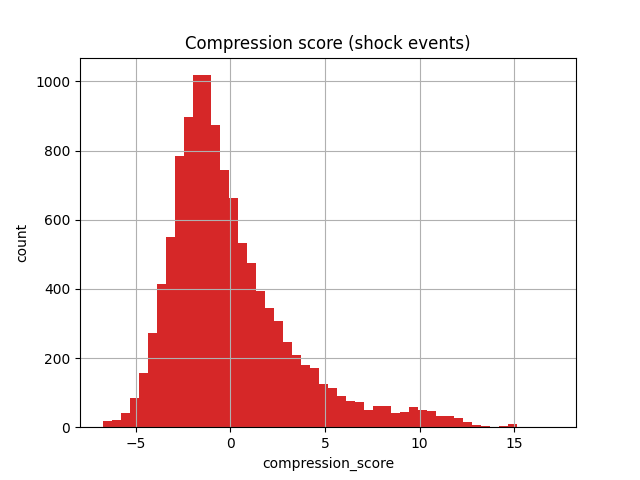

In [48]:
import matplotlib.pyplot as plt

ax = event_features_df["compression_score"].hist(bins=50)
ax.set_title("Compression score (shock events)")
ax.set_xlabel("compression_score")
ax.set_ylabel("count")
plt.show()


## Non-Shock histogramming

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BAR_MINUTES = 5
PRE_BARS  = 12 * 60 // BAR_MINUTES   # 144
BASE_BARS = 72 * 60 // BAR_MINUTES   # 864

# extra exclusion after shock to avoid post-shock regime bleeding into "non-event"
POST_EXCLUDE_BARS = 12   # 1h = 12 bars


In [50]:
def build_forbidden_mask(df_index, event_ts_list, pre_bars=PRE_BARS, post_bars=POST_EXCLUDE_BARS):
    n = len(df_index)
    forbid = np.zeros(n, dtype=bool)

    # positions of event timestamps in this df index
    # (event_ts should already be aligned; if not, nearest-match with method='pad' but that can introduce noise)
    locs = df_index.get_indexer(event_ts_list)
    locs = locs[locs >= 0]  # keep only those found

    for loc in locs:
        a = max(0, loc - pre_bars)
        b = min(n, loc + post_bars + 1)
        forbid[a:b] = True

    return forbid

rng = np.random.default_rng(42)

def sample_non_event_timestamps(dfs, events, per_symbol_cap=None):
    # group event timestamps by symbol
    ev_by_sym = events.groupby("symbol")["event_ts"].apply(list).to_dict()

    sampled = []  # list of dicts {symbol, event_ts}

    for sym, df in dfs.items():
        if sym not in ev_by_sym:
            continue

        idx = df.index
        if len(idx) <= BASE_BARS + PRE_BARS + 10:
            continue

        event_ts_list = ev_by_sym[sym]
        forbid = build_forbidden_mask(idx, event_ts_list)

        # valid candidates must:
        # - have 72h baseline available => loc >= BASE_BARS
        # - not be forbidden
        valid_mask = np.ones(len(idx), dtype=bool)
        valid_mask[:BASE_BARS] = False
        valid_mask &= ~forbid

        valid_locs = np.flatnonzero(valid_mask)
        if len(valid_locs) == 0:
            continue

        # target sample count = number of shocks for this symbol (or cap)
        k = len(event_ts_list)
        if per_symbol_cap is not None:
            k = min(k, per_symbol_cap)

        k = min(k, len(valid_locs))
        chosen_locs = rng.choice(valid_locs, size=k, replace=False)

        for loc in chosen_locs:
            sampled.append({"symbol": sym, "event_ts": idx[loc]})

    return pd.DataFrame(sampled)


In [51]:
non_events = sample_non_event_timestamps(dfs, events)
len(non_events), non_events.head()


(11614,
    symbol            event_ts
 0  0GUSDT 2025-11-30 20:20:00
 1  0GUSDT 2025-11-25 11:05:00
 2  0GUSDT 2025-10-06 02:20:00
 3  0GUSDT 2025-10-08 01:55:00
 4  0GUSDT 2025-11-14 09:30:00)

In [52]:
rows = []
for _, row in non_events.iterrows():
    sym = row["symbol"]
    ts  = row["event_ts"]
    df = dfs[sym]

    feats = extract_pre_shock_features(df, ts)
    if feats is None:
        continue

    feats["symbol"] = sym
    feats["event_ts"] = ts
    rows.append(feats)

non_event_features_df = pd.DataFrame(rows).set_index(["symbol", "event_ts"])
non_event_features_df.describe()


,vol_ratio,atr_ratio,entropy,volume_ratio,failed_breakouts
count,11614.000000,11614.000000,11614.000000,11614.000000,11614.000000
mean,0.952835,0.990102,0.080197,0.995992,5.123299
std,0.277305,0.311272,0.061416,0.515641,2.495521
min,0.073946,0.165399,0.000000,0.015012,0.000000
25%,0.766930,0.786068,0.031646,0.645449,3.000000
50%,0.928205,0.952000,0.067303,0.890785,5.000000
75%,1.109032,1.139220,0.115218,1.223721,6.000000
max,2.457851,4.379385,0.433719,5.251358,35.000000


In [53]:
z_cols = ["vol_ratio", "atr_ratio", "entropy", "volume_ratio"]

mu = event_features_df[z_cols].mean()
sd = event_features_df[z_cols].std()

for col in z_cols:
    non_event_features_df[f"z_{col}"] = (non_event_features_df[col] - mu[col]) / sd[col]

non_event_features_df["compression_score"] = non_event_features_df[
    ["z_vol_ratio", "z_atr_ratio", "z_entropy", "z_volume_ratio"]
].sum(axis=1)


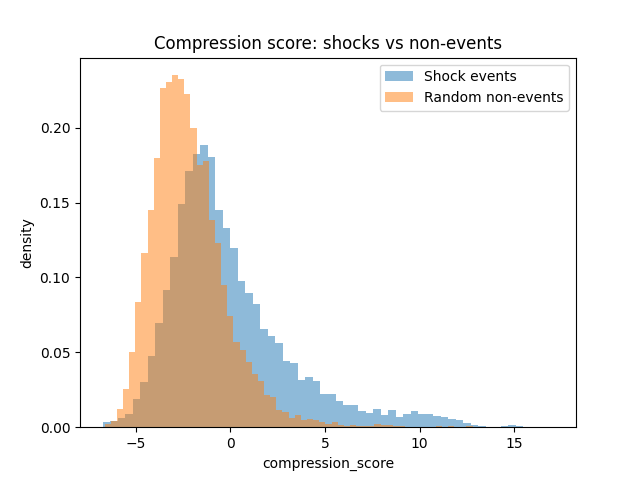

In [54]:
plt.figure()
plt.hist(event_features_df["compression_score"], bins=60, alpha=0.5, density=True, label="Shock events")
plt.hist(non_event_features_df["compression_score"], bins=60, alpha=0.5, density=True, label="Random non-events")
plt.legend()
plt.title("Compression score: shocks vs non-events")
plt.xlabel("compression_score")
plt.ylabel("density")
plt.show()


## Compression Filter

In [207]:
COMPRESSION_THRESH = -2.6
RANGE_BARS = 24   # last 2 hours

eligible_events = event_features_df[
    event_features_df["compression_score"] < COMPRESSION_THRESH
]
len(eligible_events), len(eligible_events) / len(event_features_df)


(2084, 0.18199283905335778)

In [208]:
def find_pre_shock_entry(df, event_ts):
    event_loc = df.index.get_loc(event_ts)

    pre = df.iloc[event_loc - PRE_BARS : event_loc]
    atr_pre = (pre["high"] - pre["low"]).mean()

    # compression range (last 2h)
    comp = pre.iloc[-RANGE_BARS:]
    range_high = comp["high"].max()
    range_low  = comp["low"].min()

    # scan bars after compression range
    # scan = pre.iloc[RANGE_BARS:]
    MAX_LEAD_BARS = 36   # 3 hours
    scan = pre.iloc[-MAX_LEAD_BARS:]


    for ts, row in scan.iterrows():
        body = abs(row["close"] - row["open"])

        # long
        if row["close"] > range_high and body > 0.75 * atr_pre:
            return {
                "entry_ts": ts,
                "direction": "long",
                "entry_price": row["close"]
            }

        # short
        if row["close"] < range_low and body > 0.75 * atr_pre:
            return {
                "entry_ts": ts,
                "direction": "short",
                "entry_price": row["close"]
            }

    return None


In [209]:
entries = []

for (sym, ts), row in eligible_events.iterrows():
    df = dfs[sym]
    res = find_pre_shock_entry(df, ts)
    if res is None:
        continue

    res["symbol"] = sym
    res["event_ts"] = ts
    res["compression_score"] = row["compression_score"]
    entries.append(res)

entries_df = pd.DataFrame(entries)
entries_df = entries_df.merge(
    events[["symbol","event_ts","shock_direction","impulse_signed","impulse"]],
    on=["symbol","event_ts"],
    how="left"
)

entries_df.head()


,entry_ts,direction,entry_price,symbol,event_ts,compression_score,shock_direction,impulse_signed,impulse
0,2025-09-25 21:05:00,short,3.733,0GUSDT,2025-09-26 00:00:00,-4.783366,long,0.049832,0.049832
1,2025-09-27 23:50:00,long,3.713,0GUSDT,2025-09-28 02:30:00,-4.452909,long,0.050809,0.050809
2,2025-10-02 12:40:00,long,2.696,0GUSDT,2025-10-02 15:30:00,-3.236991,long,0.049422,0.049422
3,2025-11-01 11:15:00,long,1.137,0GUSDT,2025-11-01 14:10:00,-3.406906,short,-0.044964,0.044964
4,2025-11-02 22:30:00,short,0.970,0GUSDT,2025-11-03 00:50:00,-2.760386,long,0.042945,0.042945


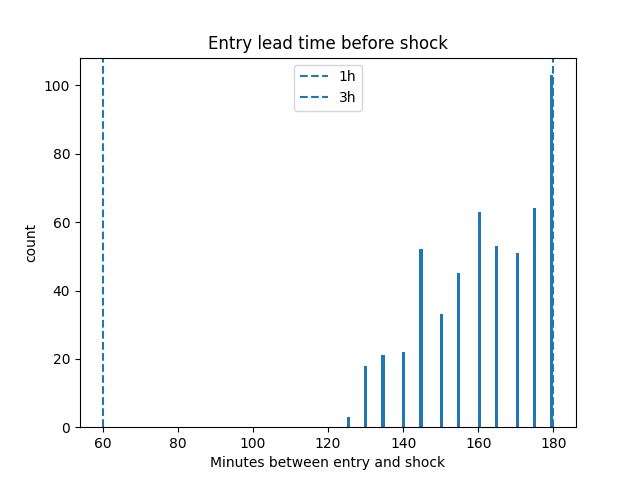

In [210]:
dt_minutes = (
    entries_df["event_ts"] - entries_df["entry_ts"]
).dt.total_seconds() / 60

plt.figure()
plt.hist(dt_minutes, bins=60)
plt.axvline(60, linestyle="--", label="1h")
plt.axvline(180, linestyle="--", label="3h")
plt.xlabel("Minutes between entry and shock")
plt.ylabel("count")
plt.title("Entry lead time before shock")
plt.legend()
plt.show()


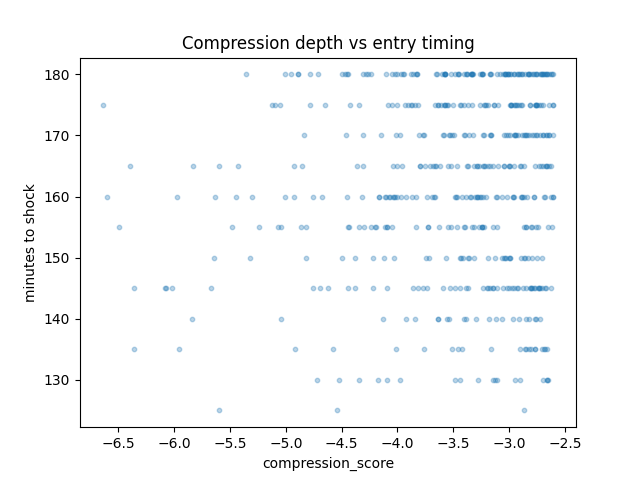

In [211]:
plt.figure()
plt.scatter(
    entries_df["compression_score"],
    dt_minutes,
    alpha=0.3,
    s=10
)
plt.xlabel("compression_score")
plt.ylabel("minutes to shock")
plt.title("Compression depth vs entry timing")
plt.show()


In [212]:
entries_df["direction"].value_counts(normalize=True)


direction
short    0.539773
long     0.460227
Name: proportion, dtype: float64

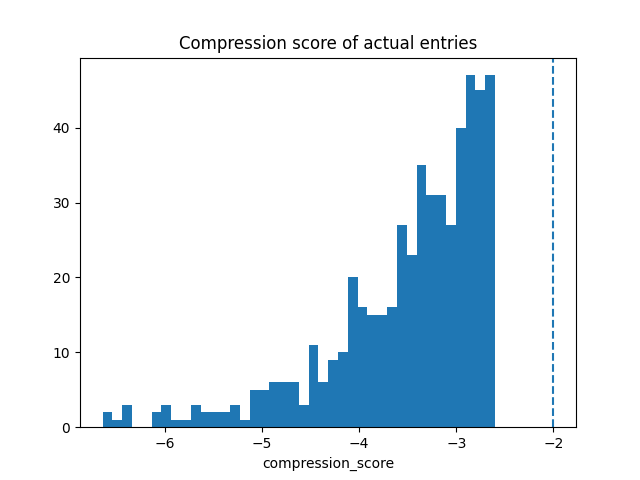

In [213]:
plt.figure()
plt.hist(entries_df["compression_score"], bins=40)
plt.axvline(-2.0, linestyle="--")
plt.xlabel("compression_score")
plt.title("Compression score of actual entries")
plt.show()


## Direction alignment filtering

In [214]:
def compute_shock_direction(row):
    sym = row["symbol"]
    event_ts = row["event_ts"]

    df = dfs[sym]

    try:
        p0 = df.loc[event_ts - pd.Timedelta(minutes=60), "close"]
        p1 = df.loc[event_ts, "close"]
    except KeyError:
        return np.nan

    ret = (p1 - p0) / p0
    return "long" if ret > 0 else "short"


In [215]:
entries_df["shock_direction"] = entries_df.apply(
    compute_shock_direction, axis=1
)
entries_df["shock_direction"].value_counts()


shock_direction
long     324
short    204
Name: count, dtype: int64

In [216]:
aligned_entries = entries_df[
    entries_df["direction"] == entries_df["shock_direction"]
]
aligned_entries["direction"].value_counts(normalize=True)


direction
long     0.69697
short    0.30303
Name: proportion, dtype: float64

In [217]:
len(entries_df), len(aligned_entries)


(528, 99)

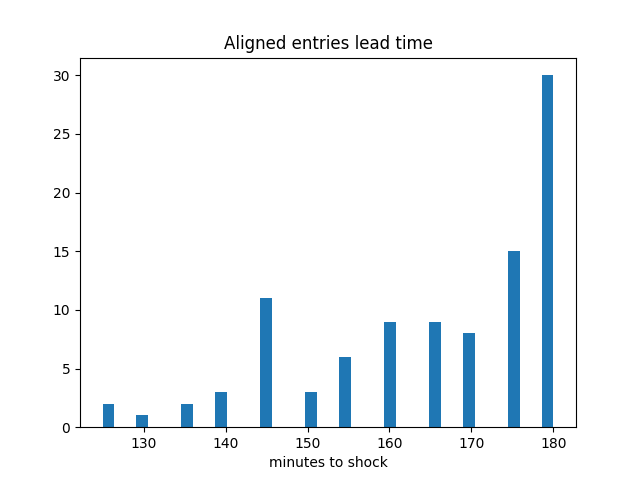

In [218]:
dt_aligned = (
    aligned_entries["event_ts"] - aligned_entries["entry_ts"]
).dt.total_seconds() / 60

plt.figure()
plt.hist(dt_aligned, bins=40)
plt.xlabel("minutes to shock")
plt.title("Aligned entries lead time")
plt.show()


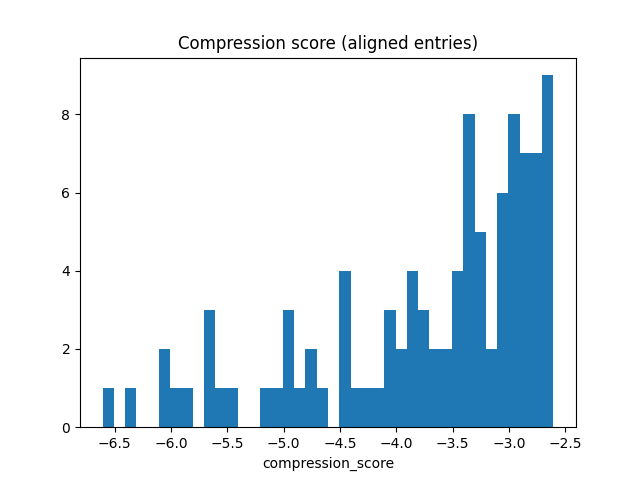

In [219]:
plt.figure()
plt.hist(aligned_entries["compression_score"], bins=40)
plt.xlabel("compression_score")
plt.title("Compression score (aligned entries)")
plt.show()


In [234]:
BAR_MINUTES = 5
FEE = 0.001  # 0.1% spot fee (round-trip will be 2x if you want later)

rows = []

for _, r in aligned_entries.iterrows():
    sym = r["symbol"]
    df  = dfs[sym]

    entry_ts = r["entry_ts"]
    event_ts = r["event_ts"]
    exit_ts  = event_ts + pd.Timedelta(minutes=BAR_MINUTES)

    # safety checks
    if entry_ts not in df.index:
        continue
    if exit_ts not in df.index:
        continue

    entry_px = df.loc[entry_ts, "close"]
    exit_px  = df.loc[exit_ts, "close"]

    if r["direction"] == "long":
        ret = (exit_px - entry_px) / entry_px
    else:  # short
        ret = (entry_px - exit_px) / entry_px

    ret_net = ret - FEE

    rows.append({
        "symbol": sym,
        "direction": r["direction"],
        "entry_ts": entry_ts,
        "event_ts": event_ts,              # ✅ keep it
        "exit_ts": exit_ts,
        "entry_px": entry_px,
        "exit_px": exit_px,
        "ret": ret,
        "ret_net": ret_net,
        "compression_score": r["compression_score"],
    })


trades = pd.DataFrame(rows)
len(trades)


99

In [235]:
def summarize(trades):
    return {
        "trades": len(trades),
        "win_rate": (trades["ret_net"] > 0).mean(),
        "avg_ret": trades["ret_net"].mean(),
        "median_ret": trades["ret_net"].median(),
        "total_ret": trades["ret_net"].sum(),
        "avg_win": trades.loc[trades["ret_net"] > 0, "ret_net"].mean(),
        "avg_loss": trades.loc[trades["ret_net"] <= 0, "ret_net"].mean(),
    }

summarize(trades)


{'trades': 99,
 'win_rate': np.float64(0.6060606060606061),
 'avg_ret': np.float64(0.006239154400510234),
 'median_ret': np.float64(0.002990422984836396),
 'total_ret': np.float64(0.6176762856505131),
 'avg_win': np.float64(0.02021555244584729),
 'avg_loss': np.float64(-0.015262996438469864)}

In [236]:
trades.groupby("direction").apply(
    lambda x: pd.Series({
        "trades": len(x),
        "win_rate": (x["ret_net"] > 0).mean(),
        "avg_ret": x["ret_net"].mean(),
    })
)


/tmp/ipykernel_941/1868759965.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades.groupby("direction").apply(


,trades,win_rate,avg_ret
direction,,,
long,69.0,0.666667,0.010213
short,30.0,0.466667,-0.002901


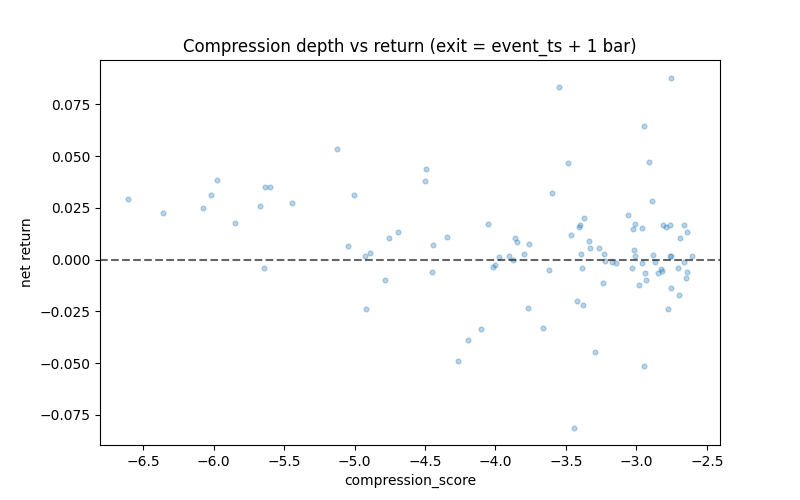

In [237]:
plt.figure(figsize=(8,5))
plt.scatter(
    trades["compression_score"],
    trades["ret_net"],
    alpha=0.3,
    s=12
)
plt.axhline(0, linestyle="--", color="k", alpha=0.6)
plt.xlabel("compression_score")
plt.ylabel("net return")
plt.title("Compression depth vs return (exit = event_ts + 1 bar)")
plt.show()


In [238]:
trades["comp_bucket"] = pd.qcut(
    trades["compression_score"],
    q=4,
    labels=["Q1 (deep)","Q2","Q3","Q4 (shallow)"]
)

bucket_stats = trades.groupby("comp_bucket")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
)

bucket_stats


/tmp/ipykernel_941/2940587472.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_stats = trades.groupby("comp_bucket")["ret_net"].agg(


,count,mean,median,win_rate
comp_bucket,,,,
Q1 (deep),25,0.018565,0.022429,0.84
Q2,25,-0.001190,0.001881,0.56
Q3,24,0.000960,0.000795,0.50
Q4 (shallow),25,0.006410,0.001876,0.52


# From this point onwards, we only consider long trades

In [239]:
long_trades = trades[trades["direction"] == "long"].copy()

long_trades["comp_bucket"] = pd.qcut(
    long_trades["compression_score"],
    q=4,
    labels=["Q1 (deep)","Q2","Q3","Q4 (shallow)"]
)

long_bucket_stats = long_trades.groupby("comp_bucket")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
)

long_bucket_stats


/tmp/ipykernel_941/671844733.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_bucket_stats = long_trades.groupby("comp_bucket")["ret_net"].agg(


,count,mean,median,win_rate
comp_bucket,,,,
Q1 (deep),18,0.021147,0.025537,0.888889
Q2,17,0.011492,0.002823,0.647059
Q3,17,-0.000221,0.002990,0.588235
Q4 (shallow),17,0.007791,0.001876,0.529412


In [240]:
long_trades = trades[trades["direction"] == "long"].copy()
len(long_trades), long_trades["symbol"].nunique()


(69, 45)

In [243]:
H1 = 24   # 2h
H2 = 72   # 6h
BAR_MIN = 5

In [244]:
def post_shock_stats_for_trade(sym, entry_ts, event_ts, direction, dfs, H):
    df = dfs[sym]
    exit_start = event_ts + pd.Timedelta(minutes=BAR_MIN)  # we avoid same-bar
    if entry_ts not in df.index or exit_start not in df.index:
        return None

    entry_px = float(df.loc[entry_ts, "close"])

    loc0 = df.index.get_loc(exit_start)
    if loc0 + H >= len(df):
        return None

    path = df["close"].iloc[loc0:loc0+H+1].astype(float).values
    # long-only assumed, but keep direction for safety
    if direction == "long":
        rets = (path - entry_px) / entry_px
    else:
        rets = (entry_px - path) / entry_px

    mfe = float(np.max(rets))
    mae = float(np.min(rets))
    ttp = int(np.argmax(rets))  # bars to peak

    ret_end = float(rets[-1])
    return mfe, mae, ttp, ret_end

rows = []
for _, r in long_trades.iterrows():
    sym = r["symbol"]
    res1 = post_shock_stats_for_trade(sym, r["entry_ts"], r["event_ts"], r["direction"], dfs, H1)
    res2 = post_shock_stats_for_trade(sym, r["entry_ts"], r["event_ts"], r["direction"], dfs, H2)
    if res1 is None or res2 is None:
        continue
    mfe1, mae1, ttp1, ret1 = res1
    mfe2, mae2, ttp2, ret2 = res2

    rows.append({
        "symbol": sym,
        "entry_ts": r["entry_ts"],
        "event_ts": r["event_ts"],
        "compression_score": r["compression_score"],
        "mfe_2h": mfe1, "mae_2h": mae1, "ttp_2h": ttp1, "ret_2h": ret1,
        "mfe_6h": mfe2, "mae_6h": mae2, "ttp_6h": ttp2, "ret_6h": ret2,
        "ret_net_v1": r["ret_net"],  # your current time-exit result
    })

post = pd.DataFrame(rows)
post.describe()


,entry_ts,event_ts,compression_score,mfe_2h,mae_2h,ttp_2h,ret_2h,mfe_6h,mae_6h,ttp_6h,ret_6h,ret_net_v1
count,68,68,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,2025-07-31 16:10:44.117647104,2025-07-31 18:57:43.235294208,-3.896660,0.041869,-0.011720,11.852941,0.018193,0.072044,-0.020473,37.250000,0.038688,0.011017
min,2025-02-04 20:10:00,2025-02-04 23:10:00,-6.606343,-0.016949,-0.074136,0.000000,-0.063184,-0.016949,-0.139291,0.000000,-0.091867,-0.033341
25%,2025-03-18 00:11:15,2025-03-18 02:53:45,-4.763471,0.012923,-0.027150,1.000000,-0.014049,0.022549,-0.043168,6.750000,-0.011008,-0.003664
50%,2025-10-05 01:15:00,2025-10-05 04:07:30,-3.471372,0.027055,-0.008386,13.500000,0.008827,0.050559,-0.017219,45.000000,0.029885,0.007677
75%,2025-10-18 15:02:30,2025-10-18 17:47:30,-2.959291,0.066954,0.002173,22.000000,0.041315,0.106471,0.000215,62.000000,0.087370,0.021975
max,2026-01-27 16:30:00,2026-01-27 19:15:00,-2.643204,0.211087,0.061332,24.000000,0.199360,0.385928,0.032076,72.000000,0.370311,0.088038
std,NaN,NaN,1.126029,0.043418,0.024859,9.401913,0.050308,0.074064,0.032810,27.061221,0.075196,0.022203


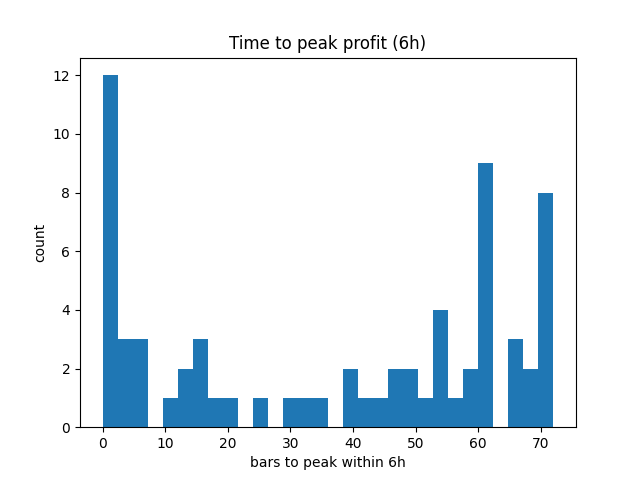

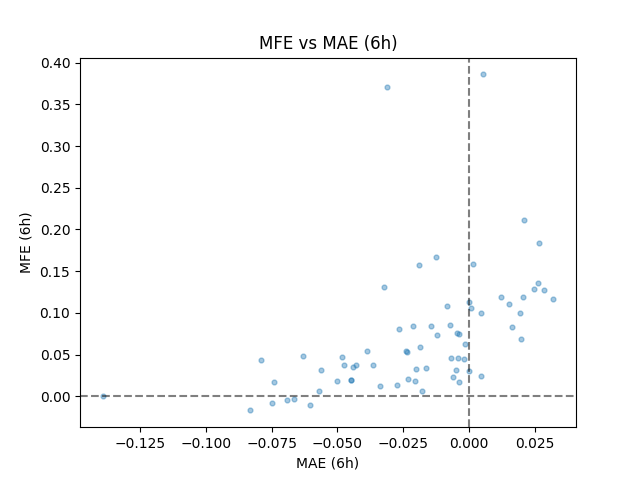

In [245]:
plt.figure()
plt.hist(post["ttp_6h"], bins=30)
plt.xlabel("bars to peak within 6h")
plt.ylabel("count")
plt.title("Time to peak profit (6h)")
plt.show()

plt.figure()
plt.scatter(post["mae_6h"], post["mfe_6h"], alpha=0.4, s=12)
plt.axhline(0, linestyle="--", color="k", alpha=0.5)
plt.axvline(0, linestyle="--", color="k", alpha=0.5)
plt.xlabel("MAE (6h)")
plt.ylabel("MFE (6h)")
plt.title("MFE vs MAE (6h)")
plt.show()


In [291]:
import numpy as np
import pandas as pd

def ATR(df, n=14):
    """
    Simple ATR (rolling mean of True Range)
    Assumes df has columns: high, low, close
    """
    high = df["high"]
    low  = df["low"]
    close = df["close"]

    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low  - close.shift()).abs(),
    ], axis=1).max(axis=1)

    return tr.rolling(n).mean()


def trailing_params_from_compression(comp_score):
    """
    Compression-aware trailing parameters.
    More negative comp_score => deeper compression => allow more room.
    """
    if comp_score <= -4.5:      # deep
        return dict(ACTIVATE_ATR=2.5, TRAIL_RETRACE=0.45, DEAD_BARS=36, DEAD_MFE_ATR=1.5)
    elif comp_score <= -3.8:    # Q2
        return dict(ACTIVATE_ATR=2.0, TRAIL_RETRACE=0.40, DEAD_BARS=30, DEAD_MFE_ATR=1.2)
    elif comp_score <= -3.2:    # Q3
        return dict(ACTIVATE_ATR=1.6, TRAIL_RETRACE=0.35, DEAD_BARS=24, DEAD_MFE_ATR=1.0)
    else:                       # shallow
        return dict(ACTIVATE_ATR=1.3, TRAIL_RETRACE=0.30, DEAD_BARS=18, DEAD_MFE_ATR=0.8)


def simulate_long_exit(
    df, entry_ts, event_ts, entry_px,
    compression_score,                 # <-- REQUIRED now (for compression-aware trailing)
    H_MAX=72, BAR_MIN=5, FEE=0.001,
    ATR_N=14,
    STOP_ATR=1.2,
    TIME_STOP_BARS=72,

    # ------------------------
    # Phase A: validation gate
    # ------------------------
    A_BARS=3,              # validate within first N bars after event+1
    A_MFE_ATR=0.6,         # must achieve at least this MFE (in ATR units)
    A_EARLY_STOP_ATR=1.0,  # optional: early stop during Phase A (ATR units)
    A_USE_EARLY_STOP=True,
):
    """
    Long-only post-shock exit simulator:
      - Start management at event_ts + 1 bar
      - Phase A gate (early validation)
      - Compression-aware trailing activation + giveback
      - Hard stop, time cap
    """

    # 0) start management from event_ts + 1 bar
    start_ts = event_ts + pd.Timedelta(minutes=BAR_MIN)
    if entry_ts not in df.index:
        return None
    if start_ts not in df.index:
        return None

    loc0 = df.index.get_loc(start_ts)

    # ATR series
    atr = ATR(df, n=ATR_N)
    if loc0 >= len(atr) or not np.isfinite(atr.iloc[loc0]):
        return None

    atr0 = float(atr.iloc[loc0])

    # Compression-aware parameters (override)
    params = trailing_params_from_compression(float(compression_score))
    ACTIVATE_ATR  = float(params["ACTIVATE_ATR"])
    TRAIL_RETRACE = float(params["TRAIL_RETRACE"])
    DEAD_BARS     = int(params["DEAD_BARS"])
    DEAD_MFE_ATR  = float(params["DEAD_MFE_ATR"])

    # Hard stop (static from ATR0)
    hard_stop_px = entry_px - STOP_ATR * atr0

    # ------------------------
    # Phase A: validation gate
    # ------------------------
    a_end_loc = min(loc0 + A_BARS - 1, len(df) - 1)

    mfe_A = -np.inf
    mae_A = np.inf

    for loc in range(loc0, a_end_loc + 1):
        close = float(df["close"].iloc[loc])
        r = (close - entry_px) / entry_px
        mfe_A = max(mfe_A, r)
        mae_A = min(mae_A, r)

        # Optional early stop during Phase A using ATR0
        if A_USE_EARLY_STOP and (r <= -(A_EARLY_STOP_ATR * atr0 / entry_px)):
            exit_ts = df.index[loc]
            exit_px = close
            ret = r
            ret_net = ret - FEE
            return {
                "exit_ts": exit_ts,
                "exit_px": exit_px,
                "ret": ret,
                "ret_net": ret_net,
                "mfe": float(max(0.0, mfe_A)),
                "mae": float(mae_A),
                "exit_reason": "A_EARLY_STOP",
                "trail_active": False,
                "mfe_A": float(mfe_A),
                "mae_A": float(mae_A),
                "ACTIVATE_ATR": ACTIVATE_ATR,
                "TRAIL_RETRACE": TRAIL_RETRACE,
                "DEAD_BARS": DEAD_BARS,
                "DEAD_MFE_ATR": DEAD_MFE_ATR,
            }

    # Must show minimum pop by end of Phase A
    if mfe_A < (A_MFE_ATR * atr0 / entry_px):
        exit_ts = df.index[a_end_loc]
        exit_px = float(df["close"].iloc[a_end_loc])
        ret = (exit_px - entry_px) / entry_px
        ret_net = ret - FEE
        return {
            "exit_ts": exit_ts,
            "exit_px": exit_px,
            "ret": float(ret),
            "ret_net": float(ret_net),
            "mfe": float(max(0.0, mfe_A)),
            "mae": float(mae_A),
            "exit_reason": "A_FAIL_NO_POP",
            "trail_active": False,
            "mfe_A": float(mfe_A),
            "mae_A": float(mae_A),
            "ACTIVATE_ATR": ACTIVATE_ATR,
            "TRAIL_RETRACE": TRAIL_RETRACE,
            "DEAD_BARS": DEAD_BARS,
            "DEAD_MFE_ATR": DEAD_MFE_ATR,
        }

    # If pass Phase A, continue from next bar
    loc_after_A = min(a_end_loc + 1, len(df) - 1)

    # 1) state
    mfe = max(0.0, float(mfe_A))
    mae = float(mae_A) if np.isfinite(mae_A) else 0.0
    trail_active = False

    # 2) iterate forward
    max_loc = min(loc0 + H_MAX, len(df) - 1)

    exit_ts = None
    exit_px = None
    exit_reason = None

    for loc in range(loc_after_A, max_loc + 1):
        ts = df.index[loc]
        close = float(df["close"].iloc[loc])

        ret_from_entry = (close - entry_px) / entry_px
        mfe = max(mfe, ret_from_entry)
        mae = min(mae, ret_from_entry)

        bars_since_start = loc - loc0

        # A) Hard stop
        if close <= hard_stop_px:
            exit_ts = ts
            exit_px = close
            exit_reason = "HARD_STOP"
            break

        # ATR per bar (fallback to atr0)
        atr_loc = atr.iloc[loc] if loc < len(atr) else np.nan
        atr_now = float(atr_loc) if np.isfinite(atr_loc) else atr0

        # B) Activate trailing after compression-aware expansion
        if (not trail_active) and (mfe >= (ACTIVATE_ATR * atr_now / entry_px)):
            trail_active = True

        # C) Compression-aware dead trade rule
        if bars_since_start >= DEAD_BARS:
            if mfe < (DEAD_MFE_ATR * atr_now / entry_px):
                exit_ts = ts
                exit_px = close
                exit_reason = "DEAD_TIME"
                break

        # D) Compression-aware trailing giveback
        if trail_active and mfe > 0:
            if ret_from_entry <= (1.0 - TRAIL_RETRACE) * mfe:
                exit_ts = ts
                exit_px = close
                exit_reason = "TRAIL_GIVEBACK"
                break

        # E) Time cap
        if bars_since_start >= TIME_STOP_BARS:
            exit_ts = ts
            exit_px = close
            exit_reason = "TIME_CAP"
            break

    # If never exited in loop
    if exit_ts is None:
        exit_ts = df.index[max_loc]
        exit_px = float(df["close"].iloc[max_loc])
        exit_reason = "END_OF_WINDOW"

    ret = (exit_px - entry_px) / entry_px
    ret_net = ret - FEE

    return {
        "exit_ts": exit_ts,
        "exit_px": float(exit_px),
        "ret": float(ret),
        "ret_net": float(ret_net),
        "mfe": float(mfe),
        "mae": float(mae),
        "exit_reason": exit_reason,
        "trail_active": bool(trail_active),
        "mfe_A": float(mfe_A),
        "mae_A": float(mae_A),
        "ACTIVATE_ATR": ACTIVATE_ATR,
        "TRAIL_RETRACE": TRAIL_RETRACE,
        "DEAD_BARS": DEAD_BARS,
        "DEAD_MFE_ATR": DEAD_MFE_ATR,
    }


In [267]:
results = []
for _, r in long_trades.iterrows():
    sym = r["symbol"]
    df  = dfs[sym]

    out = simulate_long_exit(
        df=df,
        entry_ts=r["entry_ts"],
        event_ts=r["event_ts"],
        entry_px=r["entry_px"],
        H_MAX=72
    )
    if out is None:
        continue

    results.append({
        "symbol": sym,
        "entry_ts": r["entry_ts"],
        "event_ts": r["event_ts"],
        "entry_px": r["entry_px"],
        "compression_score": r.get("compression_score", np.nan),
        **out
    })

trades_v2 = pd.DataFrame(results)


In [269]:
trades_v2[["ret_net","mfe","mae","exit_reason","trail_active"]].isna().mean()

ret_net         0.0
mfe             0.0
mae             0.0
exit_reason     0.0
trail_active    0.0
dtype: float64

In [270]:
def summarize(df):
    return pd.Series({
        "trades": len(df),
        "win_rate": (df["ret_net"] > 0).mean(),
        "avg_ret": df["ret_net"].mean(),
        "median_ret": df["ret_net"].median(),
        "total_ret": df["ret_net"].sum(),
        "avg_win": df.loc[df["ret_net"] > 0, "ret_net"].mean(),
        "avg_loss": df.loc[df["ret_net"] <= 0, "ret_net"].mean(),
    })

summarize(trades_v2)


trades        69.000000
win_rate       0.565217
avg_ret        0.006299
median_ret     0.004769
total_ret      0.434613
avg_win        0.026958
avg_loss      -0.020558
dtype: float64

In [271]:
trades_v2.groupby("exit_reason")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
).sort_values("count", ascending=False)


,count,mean,median,win_rate
exit_reason,,,,
TRAIL_GIVEBACK,37,0.018536,0.016242,0.972973
HARD_STOP,29,-0.020526,-0.019059,0.000000
TIME_CAP,3,0.114679,0.115856,1.000000


In [272]:
base = trades.copy()
base = base[base["direction"]=="long"].copy()

v2 = trades_v2.copy()

# merge on unique trade key: symbol + entry_ts + event_ts
m = base.merge(
    v2,
    on=["symbol","entry_ts","event_ts"],
    how="inner",
    suffixes=("_base","_v2")
)

len(base), len(v2), len(m)


(69, 69, 69)

In [273]:
summarize(m.rename(columns={"ret_net_base":"ret_net"})), summarize(m.rename(columns={"ret_net_v2":"ret_net"}))


(trades        69.000000
 win_rate       0.666667
 avg_ret        0.010213
 median_ret     0.006463
 total_ret      0.704704
 avg_win        0.021128
 avg_loss      -0.011617
 dtype: float64,
 trades        69.000000
 win_rate       0.565217
 avg_ret        0.006299
 median_ret     0.004769
 total_ret      0.434613
 avg_win        0.026958
 avg_loss      -0.020558
 dtype: float64)

In [274]:
(m["ret_net_v2"] - m["ret_net_base"]).describe()


count    69.000000
mean     -0.003914
std       0.029357
min      -0.081902
25%      -0.019926
50%      -0.010391
75%       0.005210
max       0.111613
dtype: float64

In [275]:
m["mfe_capture"] = m["ret_v2"] / m["mfe"]   # uses v2 ret + v2 mfe
m["mfe_capture"].replace([np.inf, -np.inf], np.nan, inplace=True)

m["mfe_capture"].describe()


/tmp/ipykernel_941/3041568529.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  m["mfe_capture"].replace([np.inf, -np.inf], np.nan, inplace=True)


count     57.000000
mean      -2.284059
std       14.194938
min     -106.000000
25%       -0.993103
50%        0.461538
75%        0.600000
max        1.000000
Name: mfe_capture, dtype: float64

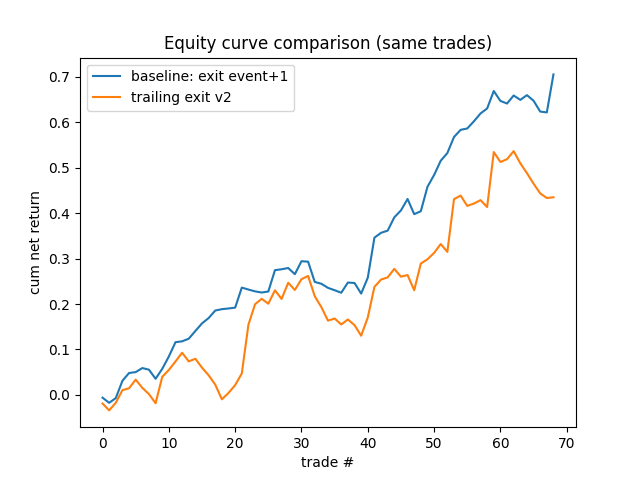

In [276]:
plt.figure()
plt.plot(np.cumsum(m["ret_net_base"].values), label="baseline: exit event+1")
plt.plot(np.cumsum(m["ret_net_v2"].values), label="trailing exit v2")
plt.legend()
plt.title("Equity curve comparison (same trades)")
plt.xlabel("trade #")
plt.ylabel("cum net return")
plt.show()


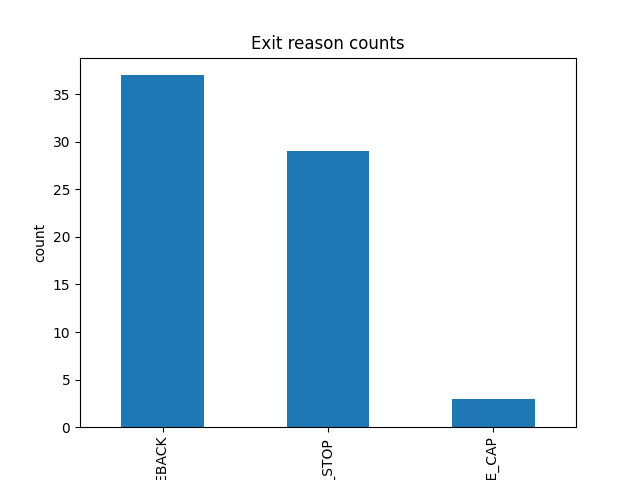

In [277]:
plt.figure()
trades_v2["exit_reason"].value_counts().plot(kind="bar")
plt.title("Exit reason counts")
plt.ylabel("count")
plt.show()


In [278]:
trades_v2.groupby(pd.qcut(trades_v2["compression_score"], 4))[
    ["ret_net", "mfe", "mae"]
].mean()


/tmp/ipykernel_941/807802889.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trades_v2.groupby(pd.qcut(trades_v2["compression_score"], 4))[


,ret_net,mfe,mae
compression_score,,,
"(-6.607, -4.757]",0.023664,0.044823,-0.004769
"(-4.757, -3.461]",-0.000222,0.026306,-0.010391
"(-3.461, -2.959]",-0.004847,0.019671,-0.013629
"(-2.959, -2.643]",0.005578,0.027522,-0.009602


In [281]:
results = []
for _, r in long_trades.iterrows():
    sym = r["symbol"]
    df  = dfs[sym]

    out = simulate_long_exit(
        df=df,
        entry_ts=r["entry_ts"],
        event_ts=r["event_ts"],
        entry_px=r["entry_px"],
        H_MAX=72
    )
    if out is None:
        continue

    results.append({
        "symbol": sym,
        "entry_ts": r["entry_ts"],
        "event_ts": r["event_ts"],
        "entry_px": r["entry_px"],
        "compression_score": r.get("compression_score", np.nan),
        **out
    })

trades_v3 = pd.DataFrame(results)

In [282]:
summarize(trades_v3)

trades_v3.groupby("exit_reason")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
).sort_values("count", ascending=False)


,count,mean,median,win_rate
exit_reason,,,,
TRAIL_GIVEBACK,23,0.024936,0.017217,0.956522
A_EARLY_STOP,14,-0.021089,-0.019403,0.000000
A_FAIL_NO_POP,13,-0.005464,-0.004407,0.153846
HARD_STOP,11,-0.017673,-0.018086,0.000000
TIME_CAP,8,0.102326,0.104103,1.000000


In [283]:
trades_v3.groupby(["exit_reason", pd.qcut(trades_v3["compression_score"], 4)])["ret_net"].mean()


/tmp/ipykernel_941/1842756741.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trades_v3.groupby(["exit_reason", pd.qcut(trades_v3["compression_score"], 4)])["ret_net"].mean()


exit_reason     compression_score
A_EARLY_STOP    (-6.607, -4.757]    -0.013798
                (-4.757, -3.461]    -0.025131
                (-3.461, -2.959]    -0.023006
                (-2.959, -2.643]    -0.019304
A_FAIL_NO_POP   (-6.607, -4.757]    -0.005861
                (-4.757, -3.461]    -0.003135
                (-3.461, -2.959]    -0.008637
                (-2.959, -2.643]    -0.004533
HARD_STOP       (-6.607, -4.757]          NaN
                (-4.757, -3.461]    -0.018113
                (-3.461, -2.959]    -0.017882
                (-2.959, -2.643]    -0.016810
TIME_CAP        (-6.607, -4.757]     0.102326
                (-4.757, -3.461]          NaN
                (-3.461, -2.959]          NaN
                (-2.959, -2.643]          NaN
TRAIL_GIVEBACK  (-6.607, -4.757]     0.021031
                (-4.757, -3.461]     0.028423
                (-3.461, -2.959]     0.025501
                (-2.959, -2.643]     0.023650
Name: ret_net, dtype: float64

In [284]:
import numpy as np
import pandas as pd

def exit_policy_from_score(cs: float):
    """
    Map compression_score (more negative = deeper compression)
    to exit parameters.
    Tune the thresholds later.
    """
    if not np.isfinite(cs):
        # conservative default
        return dict(
            STOP_ATR=1.2,
            ACTIVATE_ATR=2.2,
            TRAIL_RETRACE=0.40,
            DEAD_BARS=24,
            DEAD_MFE_ATR=1.2,
            TIME_STOP_BARS=72,
            H_MAX=72,
        )

    # Deep compression: expect stronger expansion → activate earlier, trail tighter,
    # give it slightly more time to run.
    if cs <= -4.8:
        return dict(
            STOP_ATR=1.2,
            ACTIVATE_ATR=1.6,
            TRAIL_RETRACE=0.30,
            DEAD_BARS=18,
            DEAD_MFE_ATR=0.9,
            TIME_STOP_BARS=96,
            H_MAX=96,
        )

    # Medium-deep
    if cs <= -3.8:
        return dict(
            STOP_ATR=1.2,
            ACTIVATE_ATR=1.9,
            TRAIL_RETRACE=0.33,
            DEAD_BARS=24,
            DEAD_MFE_ATR=1.0,
            TIME_STOP_BARS=84,
            H_MAX=84,
        )

    # Shallow-ish (still eligible)
    if cs <= -3.0:
        return dict(
            STOP_ATR=1.2,
            ACTIVATE_ATR=2.2,
            TRAIL_RETRACE=0.38,
            DEAD_BARS=24,
            DEAD_MFE_ATR=1.2,
            TIME_STOP_BARS=72,
            H_MAX=72,
        )

    # Barely compressed (closest to threshold): require more proof; trail looser
    return dict(
        STOP_ATR=1.2,
        ACTIVATE_ATR=2.6,
        TRAIL_RETRACE=0.45,
        DEAD_BARS=18,
        DEAD_MFE_ATR=1.4,
        TIME_STOP_BARS=60,
        H_MAX=60,
    )


In [285]:
def simulate_long_exit_ca(
    df, entry_ts, event_ts, entry_px,
    compression_score,
    BAR_MIN=5, FEE=0.001,
    ATR_N=14,
):
    """
    Compression-aware long exit.
    Starts managing at event_ts + 1 bar.
    Exits on: HARD_STOP, FAIL_NO_POP, EARLY_STOP, TRAIL_GIVEBACK, TIME_CAP, END_OF_WINDOW
    """

    # 0) Pull compression-aware parameters
    P = exit_policy_from_score(float(compression_score) if compression_score is not None else np.nan)
    STOP_ATR        = P["STOP_ATR"]
    ACTIVATE_ATR    = P["ACTIVATE_ATR"]
    TRAIL_RETRACE   = P["TRAIL_RETRACE"]
    DEAD_BARS       = P["DEAD_BARS"]
    DEAD_MFE_ATR    = P["DEAD_MFE_ATR"]
    TIME_STOP_BARS  = P["TIME_STOP_BARS"]
    H_MAX           = P["H_MAX"]

    start_ts = event_ts + pd.Timedelta(minutes=BAR_MIN)
    if entry_ts not in df.index: return None
    if start_ts not in df.index: return None

    loc0 = df.index.get_loc(start_ts)

    atr = ATR(df, n=ATR_N)
    if loc0 >= len(atr) or (not np.isfinite(atr.iloc[loc0])):
        return None

    atr0 = float(atr.iloc[loc0])
    hard_stop_px = entry_px - STOP_ATR * atr0  # price units

    # State
    mfe = 0.0
    mae = 0.0
    trail_active = False
    exit_ts = None
    exit_px = None
    exit_reason = None

    max_loc = min(loc0 + int(H_MAX), len(df) - 1)

    # To help Phase-A validation: detect "no pop" early
    # We'll define "pop" as reaching +DEAD_MFE_ATR * ATR within DEAD_BARS
    popped = False

    for loc in range(loc0, max_loc + 1):
        ts = df.index[loc]
        close = float(df["close"].iloc[loc])

        ret_from_entry = (close - entry_px) / entry_px
        mfe = max(mfe, ret_from_entry)
        mae = min(mae, ret_from_entry)

        atr_now = float(atr.iloc[loc]) if np.isfinite(atr.iloc[loc]) else atr0

        # A) Hard stop
        if close <= hard_stop_px:
            exit_ts, exit_px, exit_reason = ts, close, "HARD_STOP"
            break

        bars_since_start = loc - loc0

        # "pop" detection in ATR terms
        if (not popped) and (mfe >= (DEAD_MFE_ATR * atr_now / entry_px)):
            popped = True

        # B) If after DEAD_BARS we still didn't pop → FAIL_NO_POP
        if bars_since_start >= DEAD_BARS and (not popped):
            exit_ts, exit_px, exit_reason = ts, close, "A_FAIL_NO_POP"
            break

        # C) Activate trailing only after real expansion
        if (not trail_active) and (mfe >= (ACTIVATE_ATR * atr_now / entry_px)):
            trail_active = True

        # D) Once popped but fails to progress → EARLY_STOP
        # (Example rule: after pop, if we give back too much before trail activates)
        # Keep this mild to avoid over-pruning; tune later.
        if (not trail_active) and popped and bars_since_start >= DEAD_BARS:
            # if after pop we are back near flat, kill it
            if ret_from_entry <= 0.2 * (DEAD_MFE_ATR * atr_now / entry_px):
                exit_ts, exit_px, exit_reason = ts, close, "A_EARLY_STOP"
                break

        # E) Trailing giveback
        if trail_active and mfe > 0:
            if ret_from_entry <= (1.0 - TRAIL_RETRACE) * mfe:
                exit_ts, exit_px, exit_reason = ts, close, "TRAIL_GIVEBACK"
                break

        # F) Time cap
        if bars_since_start >= TIME_STOP_BARS:
            exit_ts, exit_px, exit_reason = ts, close, "TIME_CAP"
            break

    if exit_ts is None:
        exit_ts = df.index[max_loc]
        exit_px = float(df["close"].iloc[max_loc])
        exit_reason = "END_OF_WINDOW"

    ret = (exit_px - entry_px) / entry_px
    ret_net = ret - FEE

    return dict(
        exit_ts=exit_ts,
        exit_px=exit_px,
        ret=ret,
        ret_net=ret_net,
        mfe=mfe,
        mae=mae,
        exit_reason=exit_reason,
        trail_active=trail_active,
        # audit params
        p_STOP_ATR=STOP_ATR,
        p_ACTIVATE_ATR=ACTIVATE_ATR,
        p_TRAIL_RETRACE=TRAIL_RETRACE,
        p_DEAD_BARS=DEAD_BARS,
        p_DEAD_MFE_ATR=DEAD_MFE_ATR,
        p_TIME_STOP_BARS=TIME_STOP_BARS,
        p_H_MAX=H_MAX,
    )


In [286]:
results = []

for _, r in long_trades.iterrows():
    sym = r["symbol"]
    df = dfs.get(sym)
    if df is None:
        continue

    out = simulate_long_exit_ca(
        df=df,
        entry_ts=r["entry_ts"],
        event_ts=r["event_ts"],
        entry_px=float(r["entry_px"]),
        compression_score=float(r.get("compression_score", np.nan)),
        BAR_MIN=5,
        FEE=0.001,
        ATR_N=14,
    )
    if out is None:
        continue

    results.append({
        "symbol": sym,
        "entry_ts": r["entry_ts"],
        "event_ts": r["event_ts"],
        "entry_px": float(r["entry_px"]),
        "compression_score": float(r.get("compression_score", np.nan)),
        **out
    })

trades_v4 = pd.DataFrame(results)
len(trades_v4), trades_v4["exit_reason"].value_counts()


(69,
 exit_reason
 TRAIL_GIVEBACK    35
 HARD_STOP         29
 TIME_CAP           4
 A_FAIL_NO_POP      1
 Name: count, dtype: int64)

In [287]:
def summarize(df):
    return pd.Series({
        "trades": len(df),
        "win_rate": (df["ret_net"] > 0).mean(),
        "avg_ret": df["ret_net"].mean(),
        "median_ret": df["ret_net"].median(),
        "total_ret": df["ret_net"].sum(),
        "avg_win": df.loc[df["ret_net"] > 0, "ret_net"].mean(),
        "avg_loss": df.loc[df["ret_net"] <= 0, "ret_net"].mean(),
    })

summarize(trades_v4)

trades_v4.groupby("exit_reason")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
).sort_values("count", ascending=False)


,count,mean,median,win_rate
exit_reason,,,,
TRAIL_GIVEBACK,35,0.019699,0.015992,1.0
HARD_STOP,29,-0.020526,-0.019059,0.0
TIME_CAP,4,0.086293,0.086003,1.0
A_FAIL_NO_POP,1,-0.004749,-0.004749,0.0


In [288]:
# quartiles by compression_score (deep to shallow)
trades_v4["comp_bucket"] = pd.qcut(
    trades_v4["compression_score"],
    q=4,
    labels=["Q1 (deep)", "Q2", "Q3", "Q4 (shallow)"]
)

trades_v4.groupby("comp_bucket")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
)


/tmp/ipykernel_941/3076475156.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trades_v4.groupby("comp_bucket")["ret_net"].agg(


,count,mean,median,win_rate
comp_bucket,,,,
Q1 (deep),18,0.012581,0.016114,0.833333
Q2,17,-0.001525,0.001642,0.529412
Q3,17,-0.000368,-0.017129,0.411765
Q4 (shallow),17,0.014139,-0.004749,0.470588


In [292]:
out = simulate_long_exit(
    df=df,
    entry_ts=r["entry_ts"],
    event_ts=r["event_ts"],
    entry_px=r["entry_px"],
    compression_score=r["compression_score"],
    H_MAX=72
)


In [294]:
results = []

for _, r in long_trades.iterrows():
    sym = r["symbol"]
    df  = dfs[sym]

    out = simulate_long_exit(
        df=df,
        entry_ts=r["entry_ts"],
        event_ts=r["event_ts"],
        entry_px=r["entry_px"],
        compression_score=r["compression_score"],
        H_MAX=72
    )
    if out is None:
        continue

    results.append({
        "symbol": sym,
        "entry_ts": r["entry_ts"],
        "event_ts": r["event_ts"],
        "entry_px": r["entry_px"],
        "compression_score": r["compression_score"],
        "comp_bucket": r.get("comp_bucket", np.nan),
        **out
    })

trades_v5 = pd.DataFrame(results)
trades_v5.shape


(69, 20)

In [295]:
def summarize(df):
    return pd.Series({
        "trades": len(df),
        "win_rate": (df["ret_net"] > 0).mean(),
        "avg_ret": df["ret_net"].mean(),
        "median_ret": df["ret_net"].median(),
        "total_ret": df["ret_net"].sum(),
        "avg_win": df.loc[df["ret_net"] > 0, "ret_net"].mean(),
        "avg_loss": df.loc[df["ret_net"] <= 0, "ret_net"].mean(),
    })

summarize(trades_v5)

trades_v5.groupby("exit_reason")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
).sort_values("count", ascending=False)


,count,mean,median,win_rate
exit_reason,,,,
TRAIL_GIVEBACK,22,0.015504,0.012626,0.909091
A_EARLY_STOP,14,-0.021089,-0.019403,0.000000
A_FAIL_NO_POP,13,-0.005464,-0.004407,0.153846
TIME_CAP,11,0.102763,0.105286,1.000000
HARD_STOP,9,-0.018463,-0.018953,0.000000


In [296]:
trades_v5.groupby("comp_bucket")["ret_net"].agg(
    count="count",
    mean="mean",
    median="median",
    win_rate=lambda s: (s > 0).mean()
)

,count,mean,median,win_rate
comp_bucket,,,,
Q1 (deep),22,0.050402,0.041490,0.727273
Q2,17,-0.007240,-0.014210,0.294118
Q3,14,-0.004545,-0.007680,0.357143
Q4 (shallow),16,0.001057,-0.006412,0.437500


In [297]:
base = trades[trades["direction"]=="long"].copy()

m = base.merge(
    trades_v5,
    on=["symbol","entry_ts","event_ts"],
    how="inner",
    suffixes=("_base", "_v5")
)

summarize(m.rename(columns={"ret_net_base":"ret_net"}))
summarize(m.rename(columns={"ret_net_v5":"ret_net"}))

(m["ret_net_v5"] - m["ret_net_base"]).describe()


count    69.000000
mean      0.003396
std       0.036243
min      -0.097754
25%      -0.015494
50%      -0.002132
75%       0.005577
max       0.090593
dtype: float64

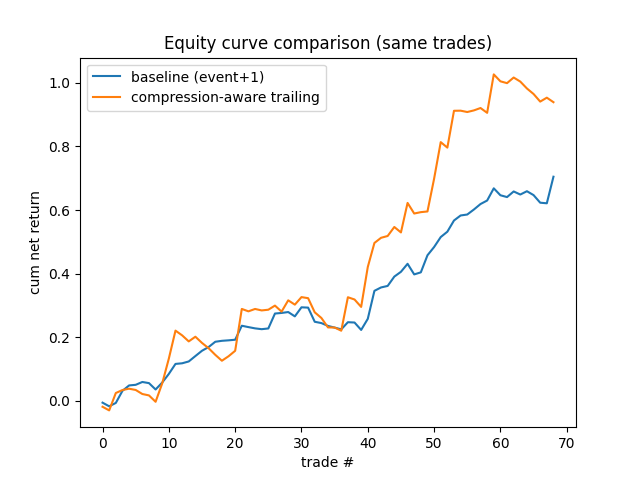

In [298]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.cumsum(m["ret_net_base"].values), label="baseline (event+1)")
plt.plot(np.cumsum(m["ret_net_v5"].values), label="compression-aware trailing")
plt.legend()
plt.title("Equity curve comparison (same trades)")
plt.xlabel("trade #")
plt.ylabel("cum net return")
plt.show()


In [299]:
trades_v5[["ret_net","mfe","mae"]].describe()
trades_v5["trail_active"].value_counts(dropna=False)
trades_v5["exit_reason"].value_counts(dropna=False)

# Any impossible cases?
(trades_v5["mfe"] < 0).sum(), (trades_v5["mae"] > 0).sum()


(np.int64(0), np.int64(28))